In [1]:
import typing

import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt


def reachedConvergence(x: np.ndarray, x_estimate: np.ndarray, grad_x0: np.ndarray,
                       grad_x: np.ndarray, tolf: float, tolx: float) -> bool:
    if np.linalg.norm(x_estimate - x, ord=2) < tolx:
        return True

    if np.linalg.norm(grad_x, ord=2) < tolf * np.linalg.norm(grad_x0, ord=2):
        return True

    return False


def backtracking(f, grad_f, x):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.

    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25

    while f(x - alpha * grad_f(x)) > f(x) - c * alpha * np.linalg.norm(grad_f(x), 2) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha


def gradientDescent(f_pars_0: np.ndarray, f: typing.Callable, f_gradient: typing.Callable,
                    alpha: float = 1e-3, kmax: int = 500, tolf: float = 1e-6, tolx: float = 1e-6,
                    use_backtracking: bool = False, verbose: bool = False):
    f_pars_estimates = np.empty((kmax + 1,) + f_pars_0.shape, dtype=np.float32)
    f_pars_estimates[0] = f_pars_0

    f_vals = np.empty((kmax,), dtype=np.float32)
    grads = np.empty((kmax,) + f_pars_0.shape, dtype=np.float32)
    errs = np.empty((kmax,), dtype=np.float32)

    for i in range(kmax):
        if (i + 1) % 100 == 0 and verbose:
            print("Running iteration %d" % (i + 1))
        f_vals[i] = f(f_pars_estimates[i])
        grads[i] = f_gradient(f_pars_estimates[i])
        errs[i] = np.linalg.norm(grads[i], ord=2)

        if use_backtracking:
            alpha = backtracking(f, f_gradient, f_pars_estimates[i, :])

        f_pars_estimates[i + 1] = f_pars_estimates[i, :] - alpha * grads[i]
        if reachedConvergence(f_pars_estimates[i + 1, :], f_pars_estimates[i, :], grads[0], grads[i], tolf, tolx):
            return f_pars_estimates[:i + 2, :], i + 1, f_vals[:i + 2], grads[:i + 2, :], errs[:i + 1]

    return f_pars_estimates, None, f_vals, grads, errs


def stochasticGradientDescent(f_pars_0: np.ndarray, f: typing.Callable, f_gradient: typing.Callable,
                              data: typing.Tuple[np.ndarray, np.ndarray], alpha: float = 1e-3, batch_size: int = 32,
                              n_epochs: int = 100, verbose: bool = False):
    n = data[0].shape[0]
    n_batchs = n // batch_size
    indexes = np.arange(n)

    f_pars_estimates = np.zeros((n_epochs + 1,) + f_pars_0.shape, dtype=np.float32)
    f_pars_estimates[0] = f_pars_0
    f_vals = np.zeros((n_epochs,), dtype=np.float32)
    grads = np.zeros((n_epochs,) + f_pars_0.shape, dtype=np.float32)
    errs = np.zeros((n_epochs,), dtype=np.float32)

    for i in range(n_epochs):
        if (i + 1) % 100 == 0 and verbose:
            print("Running epoch %d..." % (i + 1))
        np.random.shuffle(indexes)
        grad = np.zeros(f_pars_0.shape)
        for mb in range(n_batchs):
            mb_idxs = indexes[mb * batch_size: (mb + 1) * batch_size]
            grad += f_gradient(data, f_pars_estimates[i])

        f_vals[i] = f(data, f_pars_estimates[i])
        grads[i] = grad
        errs[i] = np.linalg.norm(grad, ord=2)
        f_pars_estimates[i + 1] = f_pars_estimates[i, :] - alpha * grad

    return f_pars_estimates, f_vals, grads, errs


def rmsprop(f_pars_0: np.ndarray, f: typing.Callable, f_gradient: typing.Callable, alpha: float = 1e-3,
            epsilon: float = 1e-7, rho: float = 0.9, momentum: float = 0.9, kmax: int = 500, verbose: bool = True):
    f_pars_estimate = f_pars_0.copy()
    delta_f_pars = np.zeros_like(f_pars_0)
    velocity = np.zeros_like(f_pars_0)
    for k in range(kmax):
        _loss_gradient = f_gradient(f_pars_estimate)
        velocity = rho * velocity + (1 - rho) * _loss_gradient ** 2
        if momentum == 0.0:
            delta_f_pars = -(alpha / (np.sqrt(velocity + epsilon))) * _loss_gradient
        else:
            delta_f_pars = (momentum * delta_f_pars) - ((alpha / (np.sqrt(velocity + epsilon))) * _loss_gradient)
        f_pars_estimate += delta_f_pars
        if verbose and k % 100 == 0:
            print("Step %i - The value of the loss is actually: %f" % (k, f(f_pars_estimate)))

    return f_pars_estimate


def adam(f_pars_0: np.ndarray, f: typing.Callable, f_gradient: typing.Callable, alpha: float = 1e-3,
         epsilon: float = 1e-7, beta_1: float = 0.9, beta_2: float = 0.999, kmax: int = 500, verbose: bool = True):
    f_pars_estimate = f_pars_0.copy()
    momentum = np.zeros_like(f_pars_0)
    velocity = np.zeros_like(f_pars_0)
    for k in range(kmax):
        _loss_gradient = f_gradient(f_pars_estimate)
        momentum = beta_1 * momentum + (1 - beta_1) * _loss_gradient
        velocity = beta_2 * velocity + (1 - beta_2) * _loss_gradient ** 2
        momentum_hat = momentum / (1 - beta_1 ** (k + 1))
        velocity_hat = velocity / (1 - beta_2 ** (k + 1))
        f_pars_estimate -= (alpha / (np.sqrt(velocity_hat) + epsilon)) * momentum_hat
        if verbose and k % 100 == 0:
            print("Step %i - The value of the loss is actually: %f" % (k, f(f_pars_estimate)))

    return f_pars_estimate


def generalizedVandermondeMatrix(x: np.ndarray, functions: typing.List[typing.Callable]) -> np.ndarray:
    n, k = x.shape[0], len(functions)
    phi_x = np.empty((n, k), dtype=np.float32)
    for i in range(n):
        for j in range(k):
            phi_x[i, j] = functions[j](x[i])

    return phi_x


def classicalVandermondeMatrix(x: np.ndarray, k: int) -> np.ndarray:
    functions = [
        (lambda exp: (lambda value: value ** exp))(i) for i in range(k)
    ]

    return generalizedVandermondeMatrix(x, functions)


def testProblem(k: int, n: int = 100, a: float = 0, b: float = 1, var: float = 1, theta_true: np.ndarray = None,
                vandermonde_functions: typing.List[typing.Callable] = None) -> typing.Tuple[np.ndarray, np.ndarray]:
    assert k > 0, "k must be strictly positive"
    assert var > 0, "The variance must be strictly positive"
    assert a < b, "The range given for X is invalid"

    if theta_true is None:
        theta_true = np.ones(k)
    else:
        assert theta_true.shape[0] == k, "Theta must have be of size k"

    x = np.linspace(start=a, stop=b, num=n)

    if vandermonde_functions is not None:
        phi_x = generalizedVandermondeMatrix(x, vandermonde_functions)
    else:
        phi_x = classicalVandermondeMatrix(x, k)

    epsilon = np.random.normal(loc=0.0, scale=var ** 0.5, size=(n,))
    y = phi_x @ theta_true + epsilon

    return x, y


def averageAbsoluteError(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    n = y_true.shape[0]
    return np.sum(np.abs(y_true - y_pred), axis=0).reshape(-1) / n


def polynomialRegressorError(test_set: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray) -> float:
    x_test, y_test = test_set
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x_test, k)
    f_theta = phi_x @ theta
    return averageAbsoluteError(y_test, f_theta)


def MLEPolynomlialRegressionLoss(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray,
                                 sigma_estimate: float = 1.0):
    x, y = data
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)
    f_theta = phi_x @ theta

    return 1 / (2 * sigma_estimate ** 2) * np.linalg.norm((f_theta - y), ord=2) ** 2


def MLEPolynomlialRegressionLossGradient(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray,
                                         sigma_estimate: float = 1.0):
    x, y = data
    n = x.shape[0]
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)
    f_theta = phi_x @ theta

    return (1 / (sigma_estimate ** 2)) * phi_x.T @ (f_theta - y) / n


def MAPPolynomlialRegressionLoss(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray,
                                 regularization_parameter: float = 1.0):
    x, y = data
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)
    f_theta = phi_x @ theta

    return np.linalg.norm((f_theta - y), ord=2) ** 2 / 2 + \
           (regularization_parameter / 2) * np.linalg.norm(theta, ord=2) ** 2


def MAPPolynomlialRegressionLossGradient(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray,
                                         regularization_parameter: float = 1.0):
    x, y = data
    n = x.shape[0]
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)
    f_theta = phi_x @ theta

    return (phi_x.T @ (f_theta - y) / n) + (regularization_parameter * theta) / n


def MLEPolynomialRegression(data: typing.Tuple[np.ndarray, np.ndarray], k: int, sigma_estimate: float = 1.0,
                            solving_strategy: str = "exact", alpha: float = 1e-3, kmax: int = 5000) -> np.ndarray:
    assert solving_strategy in ["exact", "gd", "sgd", "rmsprop", "adam"], \
        "Solving strategy must be one among \"exact\", \"gd\", \"sgd\", \"rmsprop\", and \"adam\""

    x, y = data
    phi_x = classicalVandermondeMatrix(x, k)

    if solving_strategy == "exact":
        theta = np.linalg.inv(phi_x.T @ phi_x) @ phi_x.T @ y

        return theta

    loss = lambda t: MLEPolynomlialRegressionLoss(data, t, sigma_estimate)
    loss_gradient = lambda t: MLEPolynomlialRegressionLossGradient(data, t, sigma_estimate)

    if solving_strategy == "gd":
        theta = np.random.random((k,))
        theta_estimates, k, f_vals, grads, errs = gradientDescent(theta, loss, loss_gradient, kmax=kmax,
                                                                  verbose=False, use_backtracking=True)

        return theta_estimates[-1]

    elif solving_strategy == "rmsprop":
        theta = np.random.random((k,))
        theta_estimates = rmsprop(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    elif solving_strategy == "adam":
        theta = np.random.random((k,))
        theta_estimates = adam(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    else:
        theta = np.random.random((k,))
        loss = lambda d, t: MLEPolynomlialRegressionLoss(d, t, sigma_estimate)
        loss_gradient = lambda d, t: MLEPolynomlialRegressionLossGradient(d, t, sigma_estimate)
        theta_estimates, f_vals, grads, errs = stochasticGradientDescent(f_pars_0=theta, f=loss,
                                                                         f_gradient=loss_gradient,
                                                                         data=(x, y), alpha=alpha, batch_size=100,
                                                                         n_epochs=kmax, verbose=False)

        return theta_estimates[-1]


def MAPPolynomialRegression(data: typing.Tuple[np.ndarray, np.ndarray], k: int, regularization_parameter: float,
                            solving_strategy: str = "exact", alpha: float = 1e-3, kmax: int = 100) -> np.ndarray:
    assert solving_strategy in ["exact", "gd", "sgd", "rmsprop", "adam"], \
        "Solving strategy must be one among \"exact\", \"gd\", \"sgd\", \"rmsprop\", and \"adam\""

    x, y = data
    phi_x = classicalVandermondeMatrix(x, k)

    if solving_strategy == "exact":
        theta = np.linalg.inv(phi_x.T @ phi_x + regularization_parameter * np.eye(k, dtype=x.dtype)) @ phi_x.T @ y

        return theta

    loss = lambda t: MAPPolynomlialRegressionLoss(data, t, regularization_parameter)
    loss_gradient = lambda t: MAPPolynomlialRegressionLossGradient(data, t, regularization_parameter)

    if solving_strategy == "gd":
        theta = np.random.random((k,))
        theta_estimates, k, f_vals, grads, errs = gradientDescent(theta, loss, loss_gradient, kmax=kmax,
                                                                  verbose=False, use_backtracking=True)

        return theta_estimates[-1]

    elif solving_strategy == "rmsprop":
        theta = np.random.random((k,))
        theta_estimates = rmsprop(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    elif solving_strategy == "adam":
        theta = np.random.random((k,))
        theta_estimates = adam(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    else:
        theta = np.random.random((k,))
        loss = lambda d, t: MAPPolynomlialRegressionLoss(d, t, regularization_parameter)
        loss_gradient = lambda d, t: MAPPolynomlialRegressionLossGradient(d, t, regularization_parameter)
        theta_estimates, f_vals, grads, errs = stochasticGradientDescent(f_pars_0=theta, f=loss,
                                                                         f_gradient=loss_gradient,
                                                                         data=(x, y), alpha=alpha, batch_size=100,
                                                                         n_epochs=kmax, verbose=False)

        return theta_estimates[-1]


def testProblemPoisson(k: int, n: int = 100, a: float = 0, b: float = 1,
                       theta_true: np.ndarray = None) -> typing.Tuple[np.ndarray, np.ndarray]:
    assert k > 0, "k must be strictly positive"
    assert a < b, "The range given for X is invalid"

    if theta_true is None:
        theta_true = np.ones(k)
    else:
        assert theta_true.shape[0] == k, "Theta must have be of size k"

    x = np.linspace(start=a, stop=b, num=n)
    phi_x = classicalVandermondeMatrix(x, k)

    y = phi_x @ theta_true
    epsilon = np.random.poisson(y, y.shape[0])

    return x, epsilon


def MLEPolynomlialRegressionPoissonLoss(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray):
    x, y = data
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)
    f_theta = phi_x @ theta

    return np.sum(stats.poisson.logpmf(k=y, mu=f_theta), axis=0) / x.shape[0]


def MLEPolynomlialRegressionPoissonLossGradient(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray):
    x, y = data
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)

    return np.sum(phi_x - (y.reshape((-1, 1)) / theta.reshape((1, -1))), axis=0) / x.shape[0]


def MAPPolynomlialRegressionPoissonLoss(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray,
                                        regularization_parameter: float = 1.0):
    x, y = data
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)
    f_theta = phi_x @ theta

    return np.sum(stats.poisson.logpmf(k=y, mu=f_theta), axis=0) / x.shape[0] + \
           regularization_parameter / 2 * np.linalg.norm(theta) ** 2


def MAPPolynomlialRegressionPoissonLossGradient(data: typing.Tuple[np.ndarray, np.ndarray], theta: np.ndarray,
                                                regularization_parameter: float = 1.0):
    x, y = data
    k = theta.shape[0]
    phi_x = classicalVandermondeMatrix(x, k)

    return np.sum(phi_x - (y.reshape((-1, 1)) / theta.reshape((1, -1))), axis=0) / x.shape[0] + \
           regularization_parameter * theta


def MLEPolynomialRegressionPoisson(data: typing.Tuple[np.ndarray, np.ndarray], k: int,
                                   solving_strategy: str = "exact", alpha: float = 1e-3,
                                   kmax: int = 500) -> np.ndarray:
    assert solving_strategy in ["exact", "gd", "sgd", "rmsprop", "adam"], \
        "Solving strategy must be one among \"exact\", \"gd\", \"sgd\", \"rmsprop\", and \"adam\""

    x, y = data
    phi_x = classicalVandermondeMatrix(x, k)

    loss = lambda t: MLEPolynomlialRegressionPoissonLoss(data, t)
    loss_gradient = lambda t: MLEPolynomlialRegressionPoissonLossGradient(data, t)

    if solving_strategy == "exact":
        theta = np.linalg.inv(phi_x.T @ phi_x) @ phi_x.T @ y

        return theta

    elif solving_strategy == "gd":
        theta = np.random.random((k,))
        theta_estimates, k, f_vals, grads, errs = gradientDescent(theta, loss, loss_gradient, kmax=kmax,
                                                                  verbose=False, use_backtracking=True)

        return theta_estimates[-1]

    elif solving_strategy == "rmsprop":
        theta = np.random.random((k,))
        theta_estimates = rmsprop(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    elif solving_strategy == "adam":
        theta = np.random.random((k,))
        theta_estimates = adam(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    else:
        theta = np.random.random((k,))
        loss = lambda d, t: MAPPolynomlialRegressionPoissonLoss(d, t)
        loss_gradient = lambda d, t: MAPPolynomlialRegressionPoissonLossGradient(d, t)
        theta_estimates, f_vals, grads, errs = stochasticGradientDescent(f_pars_0=theta, f=loss,
                                                                         f_gradient=loss_gradient,
                                                                         data=(x, y), alpha=alpha, batch_size=100,
                                                                         n_epochs=kmax, verbose=False)

        return theta_estimates[-1]


def MAPPolynomialRegressionPoisson(data: typing.Tuple[np.ndarray, np.ndarray], k: int,
                                   solving_strategy: str = "adam", regularization_parameter: float = 1.0,
                                   alpha: float = 1e-3, kmax: int = 500) -> np.ndarray:
    assert solving_strategy in ["exact", "gd", "sgd", "rmsprop", "adam"], \
        "Solving strategy must be one among \"exact\", \"gd\", \"sgd\", \"rmsprop\", and \"adam\""

    x, y = data
    phi_x = classicalVandermondeMatrix(x, k)
    loss = lambda t: MAPPolynomlialRegressionPoissonLoss(data, t, regularization_parameter)
    loss_gradient = lambda t: MAPPolynomlialRegressionPoissonLossGradient(data, t, regularization_parameter)

    if solving_strategy == "exact":
        theta = np.linalg.inv(phi_x.T @ phi_x + regularization_parameter * np.eye(k, dtype=x.dtype)) @ phi_x.T @ y
        return theta

    elif solving_strategy == "gd":
        theta = np.random.random((k,))
        theta_estimates, k, f_vals, grads, errs = gradientDescent(theta, loss, loss_gradient, kmax=kmax,
                                                                  verbose=False, use_backtracking=True)

        return theta_estimates[-1]

    elif solving_strategy == "rmsprop":
        theta = np.random.random((k,))
        theta_estimates = rmsprop(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    elif solving_strategy == "adam":
        theta = np.random.random((k,))
        theta_estimates = adam(theta, loss, loss_gradient, alpha=1e-3, kmax=kmax, verbose=False)

        return theta_estimates

    else:
        loss = lambda d, t: MAPPolynomlialRegressionPoissonLoss(d, t, regularization_parameter)
        loss_gradient = lambda d, t: MAPPolynomlialRegressionPoissonLossGradient(d, t, regularization_parameter)
        theta = np.random.random((k,))
        theta_estimates, f_vals, grads, errs = stochasticGradientDescent(f_pars_0=theta, f=loss,
                                                                         f_gradient=loss_gradient,
                                                                         data=(x, y), alpha=alpha, batch_size=100,
                                                                         n_epochs=kmax, verbose=False)

        return theta_estimates[-1]

/home/mrcr4ft/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def testMLEAndMAP(poisson: bool, true_k: int, a: float = 0, b: float = 1, n_train: int = 100, 
                  n_test: int = 100, var: float = 1.0, theta_true: np.ndarray = None, 
                  optimization: str = "gd", regularization_par: float = 1.0, kmax: int = 500,
                  alpha: float = 1e-3):
    if poisson: 
        polinomial_regression_mle = MLEPolynomialRegressionPoisson
        polinomial_regression_map = MAPPolynomialRegressionPoisson
        def f(x, var):
            return np.random.poisson(classicalVandermondeMatrix(x, true_k) @ theta_true, x.shape[0])
        noise_type = "Poisson"
        
    else:
        polinomial_regression_mle = MLEPolynomialRegression
        polinomial_regression_map = MAPPolynomialRegression
        def f(x, var):
            return classicalVandermondeMatrix(x, true_k) @ theta_true + np.random.normal(loc=0.0, scale=var ** 0.5, size=(x.shape[0],))
        noise_type="Gaussian"
    
    if theta_true is None:
        theta_true = np.ones((true_k,))
        
    x,y = testProblem(true_k, n_train, a, b, var, theta_true)
    if true_k == 1 or true_k == 2:
        test_ks = [1, 2, 3, 5]
    elif true_k == 3:
        test_ks = [1, 2, 3, 4, 5]
    else:
        test_ks = list((np.linspace(0, 4, 10) * true_k).astype("int32"))
        test_ks[0] = 1

    estimates_mle = []
    errors_train_mle = []
    errors_test_mle = []
    
    estimates_map = []
    errors_train_map = []
    errors_test_map = []
    
    phi_x = classicalVandermondeMatrix(x, true_k)
    true_y_train = phi_x @ theta_true
    
    x_test = np.random.random(size=(n_test,)) * (b - a) + a
    y_test = f(x_test, var)
    
    for pol_grade in test_ks:
        theta_mle = polinomial_regression_mle(data=(x,y), k=pol_grade, solving_strategy=optimization, alpha=alpha, kmax=kmax)
        theta_map = polinomial_regression_map(data=(x,y), k=pol_grade, regularization_parameter=regularization_par, solving_strategy=optimization, alpha=alpha, 
                                              kmax=kmax)
        
        phi_x = classicalVandermondeMatrix(x, pol_grade)
        y_test_pred_mle = phi_x @ theta_mle
        y_test_pred_map = phi_x @ theta_map
        
        error_train_mle = polynomialRegressorError((x, y), theta_mle)
        error_train_map = polynomialRegressorError((x, y), theta_map)
        error_test_mle = polynomialRegressorError((x_test, y_test), theta_mle)
        error_test_map = polynomialRegressorError((x_test, y_test), theta_map)
        
        estimates_mle.append(theta_mle)
        estimates_map.append(theta_map)
        errors_train_mle.append(error_train_mle)
        errors_train_map.append(error_train_map)
        errors_test_mle.append(error_test_mle)
        errors_test_map.append(error_test_map)
        
        plt.scatter(x, y, c="red", label="Training observations")
        plt.scatter(x_test, y_test, c="blue", label="Testing observations")
        plt.plot(x, y_test_pred_mle, c="green", label="Predictions on the test set (MLE)")
        plt.plot(x, y_test_pred_map, c="yellow", label="Predictions on the test set (MAP, lambda=%d)" % regularization_par)
        plt.plot(x, true_y_train, c="black", label="True mean")
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("MLE and MAP Polynomial Regression with assumption of underlying %s noise and polynomial degree equal to %d (true polynomial degree is: %d)" % (noise_type, pol_grade, true_k))
        plt.show()
        
    plt.plot(test_ks, errors_train_mle, c="blue", label="Error on the training set")
    plt.plot(test_ks, errors_test_mle, c="red", label="Error on the test set")
    plt.xlabel("polynomial degree")
    plt.ylabel("mean absolute error")
    plt.title("MAE as a function of the degree of the fitted polynomial (MLE estimation)")
    plt.legend()
    plt.show()
    
    plt.plot(test_ks, errors_train_mle, c="blue", label="Error on the training set")
    plt.plot(test_ks, errors_test_mle, c="red", label="Error on the test set")
    plt.xlabel("polynomial degree")
    plt.ylabel("mean absolute error")
    plt.title("MAE as a function of the degree of the fitted polynomial (MAP estimation with lambda = %d)" % regularization_par)
    plt.legend()
    plt.show()
    
    err_theta_mle = []
    err_theta_map = []
    ks_greater = []
    for idx, k in enumerate(test_ks):
        if k > true_k:
            true_theta_padded = np.zeros((k,))
            true_theta_padded[:true_k] = theta_true
            error_mle = np.linalg.norm(estimates_mle[idx] - true_theta_padded) / np.linalg.norm(true_theta_padded)
            error_map = np.linalg.norm(estimates_map[idx] - true_theta_padded) / np.linalg.norm(true_theta_padded)
            err_theta_mle.append(error_mle)
            err_theta_map.append(error_map)
            ks_greater.append(k)
            
    plt.plot(ks_greater, err_theta_mle, c="blue", label="MLE estimation")
    plt.plot(ks_greater, err_theta_map, c="red", label="MAP estimation with lambda = %d" % regularization_par)
    plt.xlabel("polynomial degree")
    plt.ylabel("error")
    plt.title("Error of theta as a function of the degree of the fitted polynomial")
    plt.legend()
    plt.show()

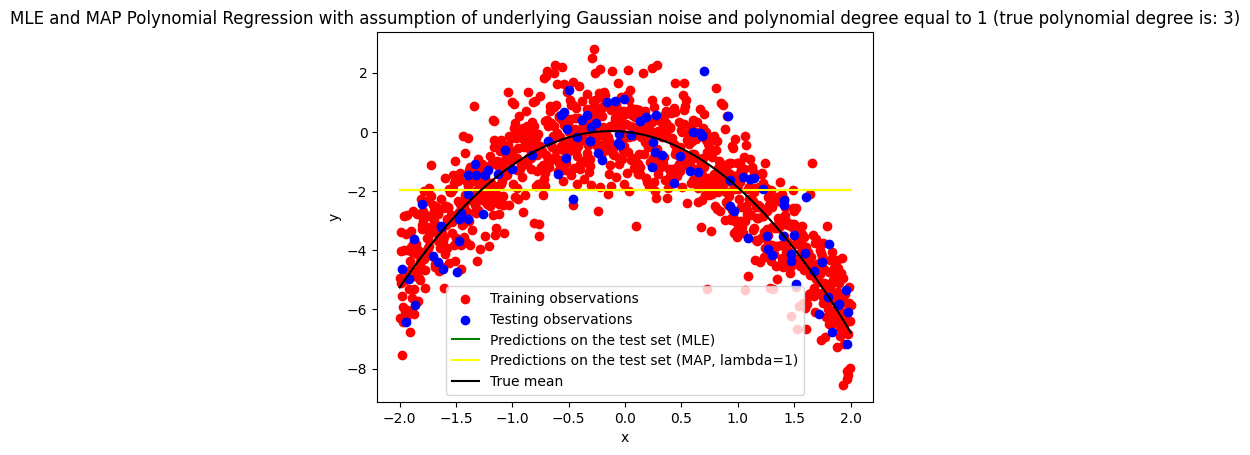

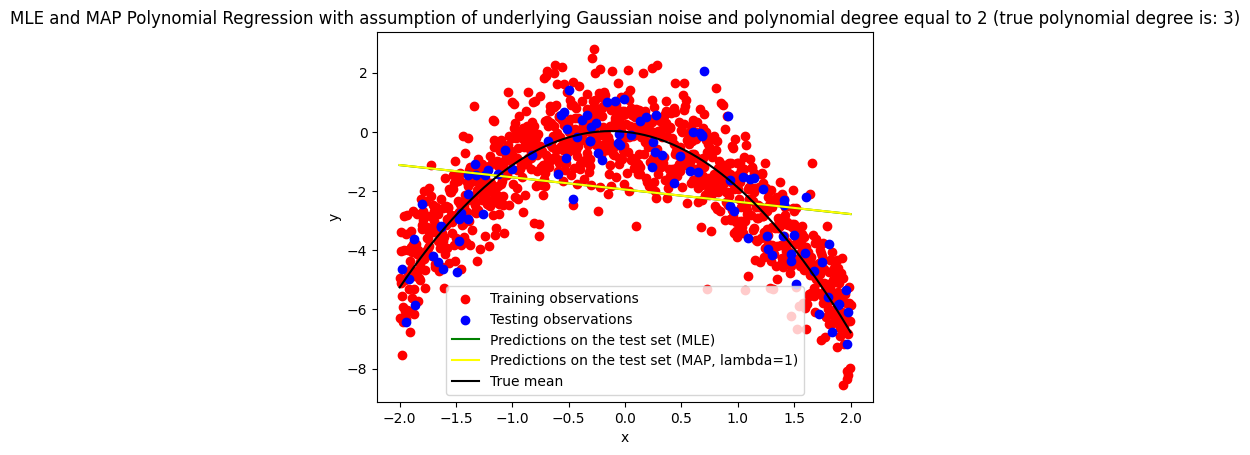

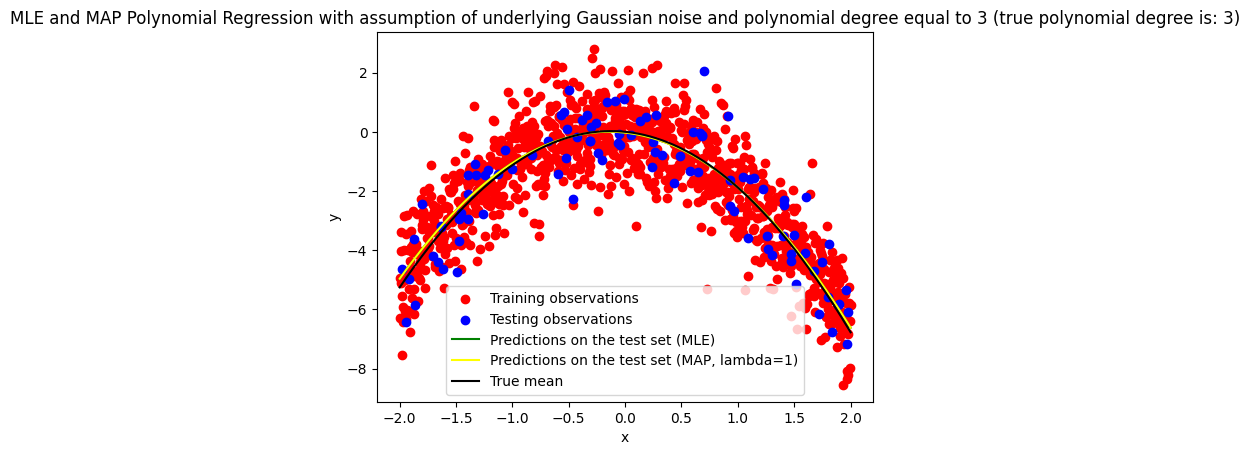

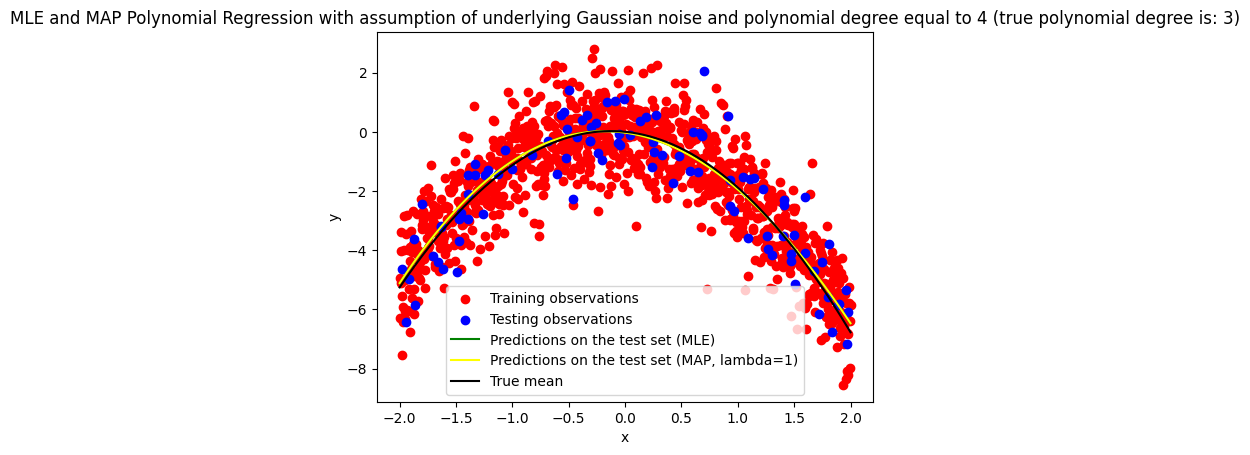

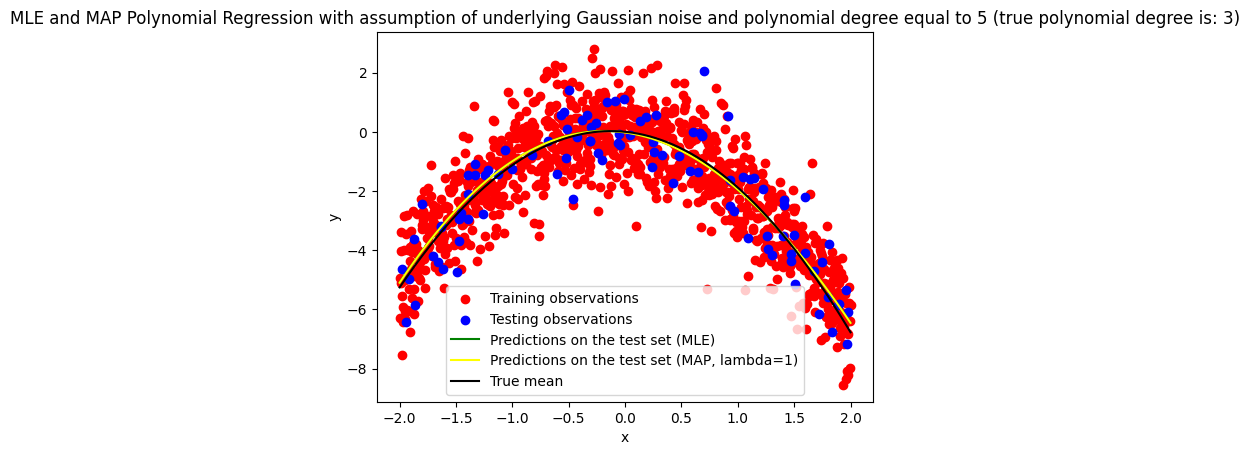

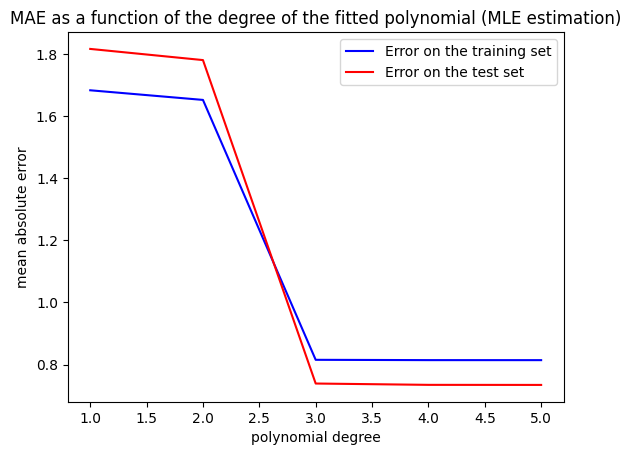

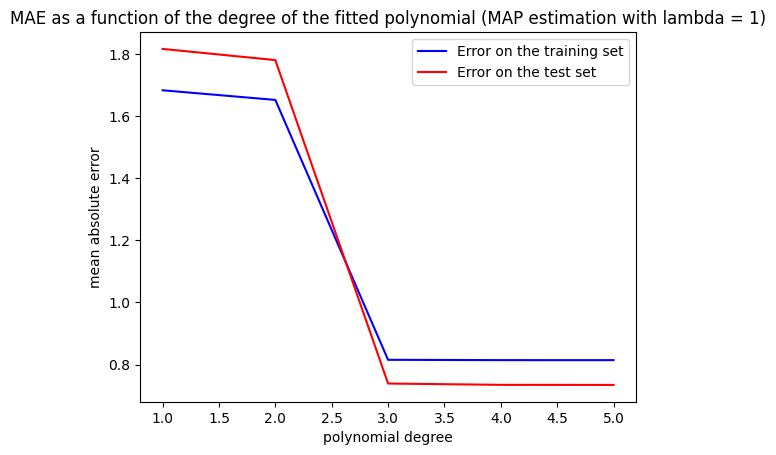

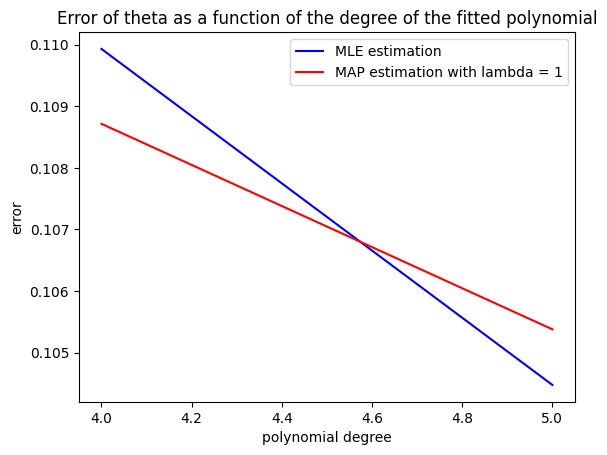

In [3]:
testMLEAndMAP(False, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.random.normal(0, 1, 3), optimization="exact", kmax=500, regularization_par=1)

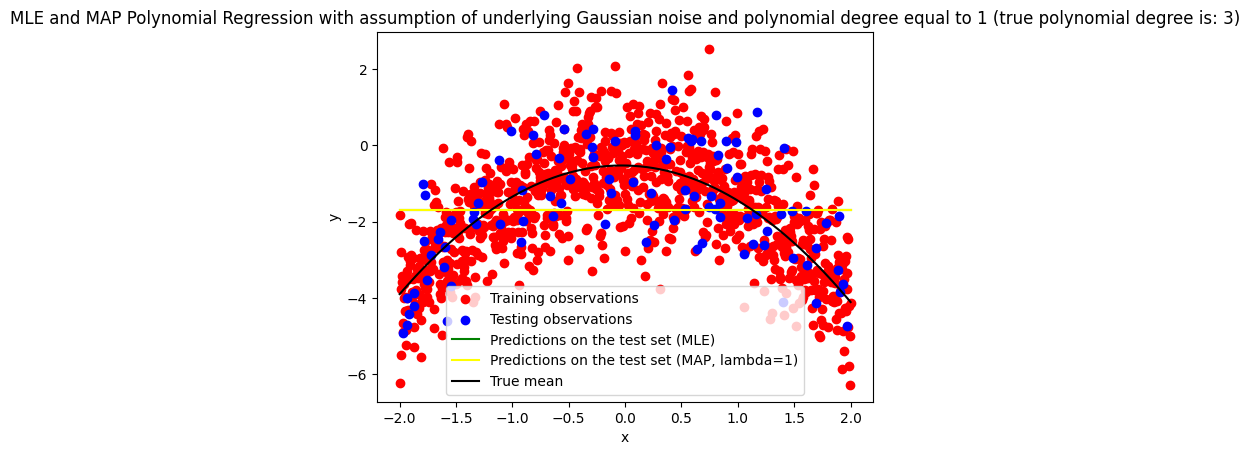

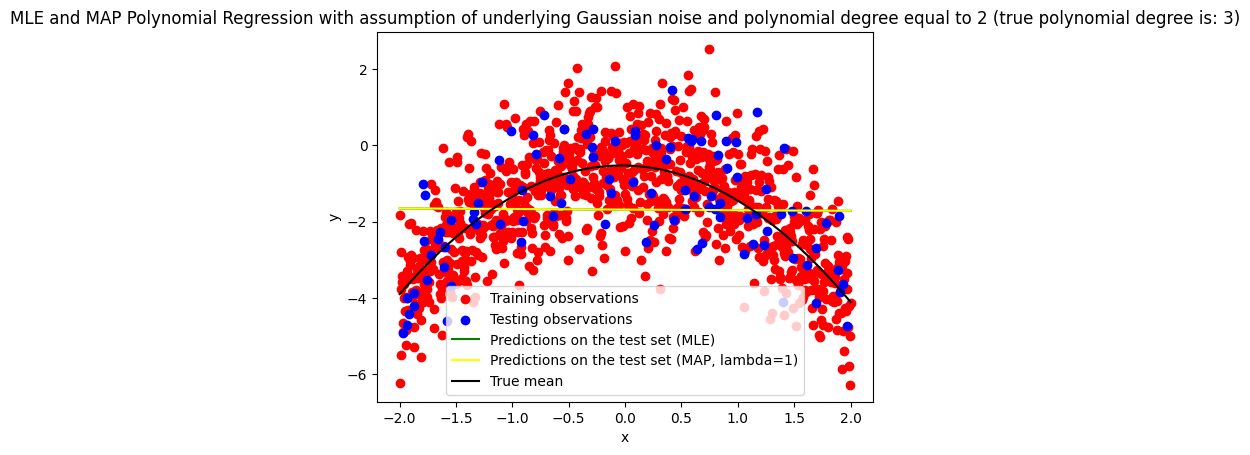

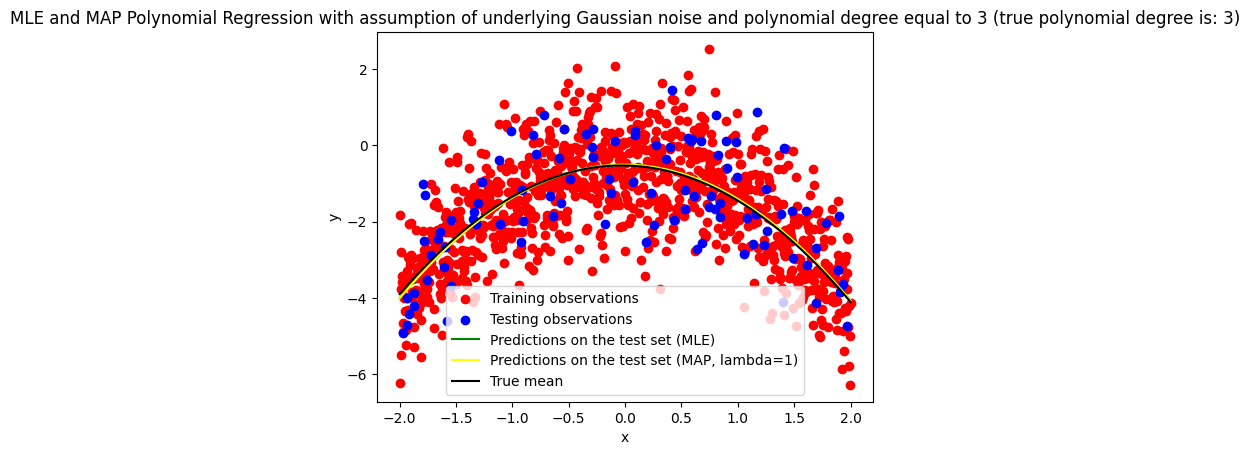

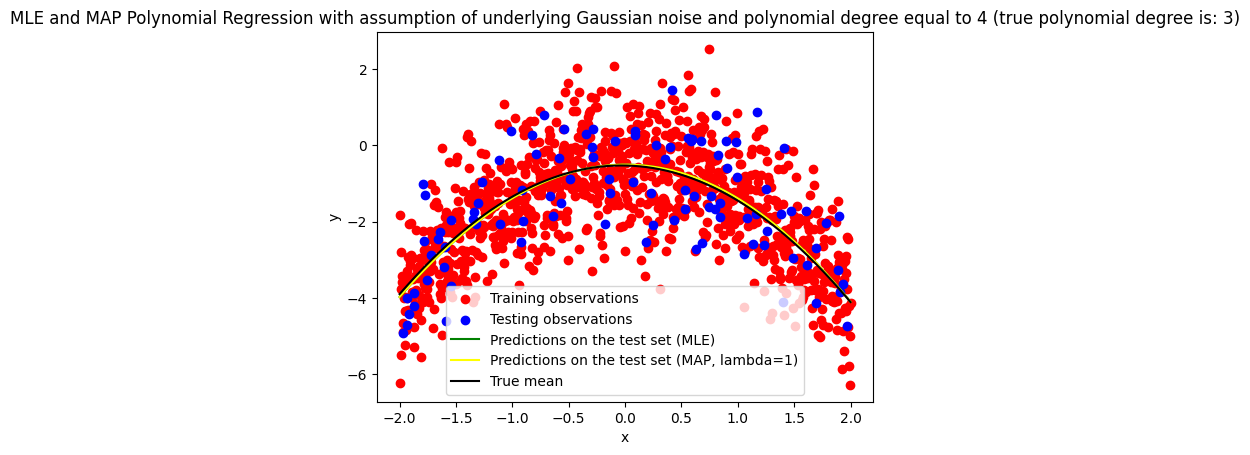

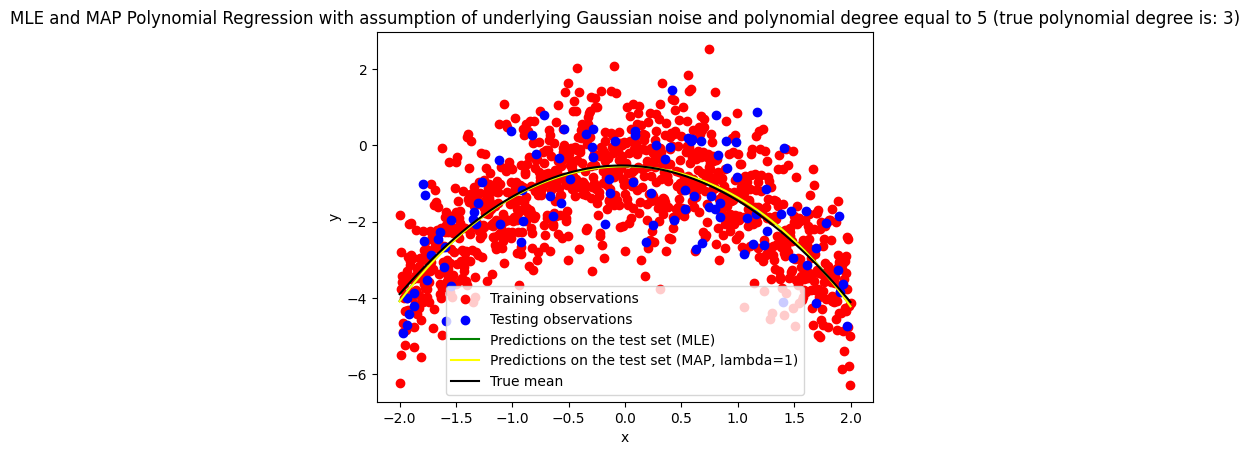

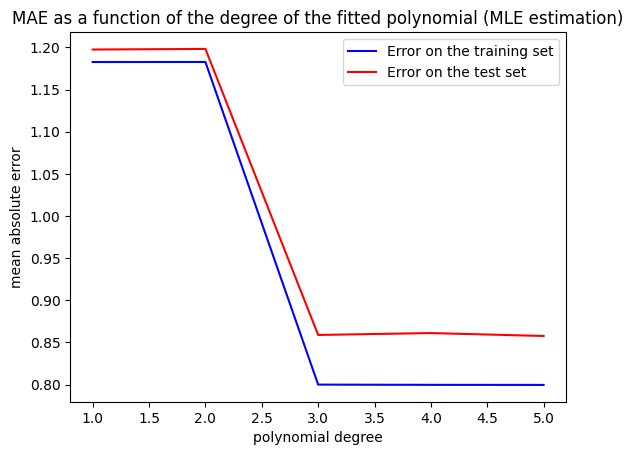

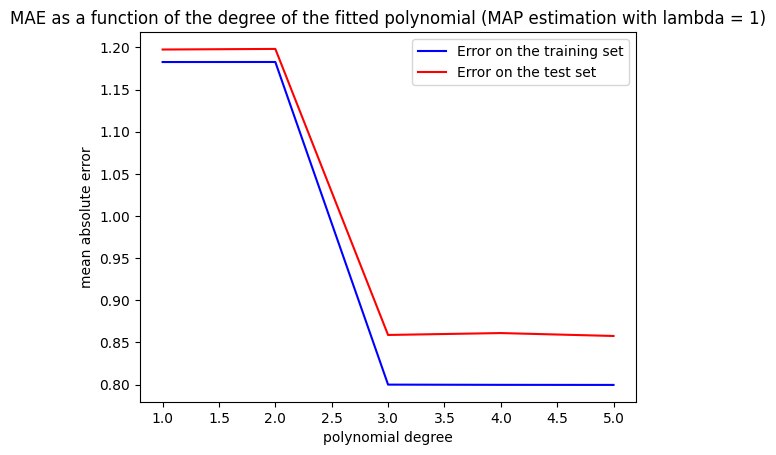

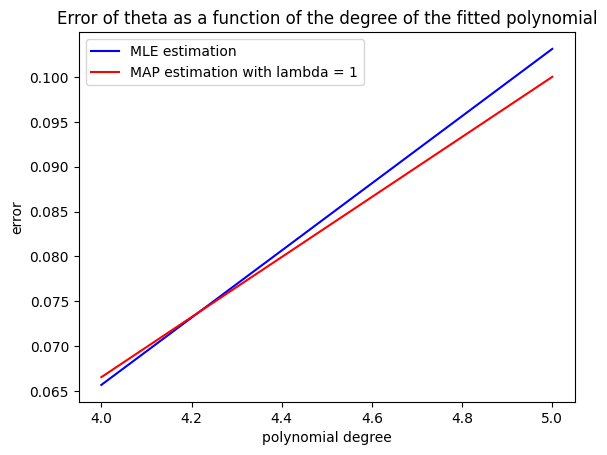

In [4]:
testMLEAndMAP(False, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.random.normal(0, 1, 3), optimization="gd", kmax=500, regularization_par=1)

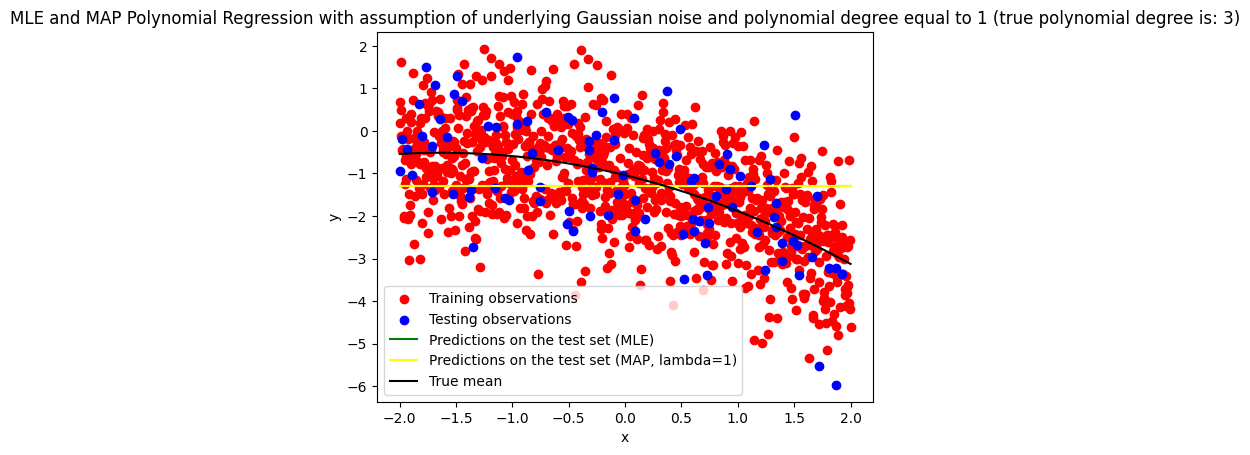

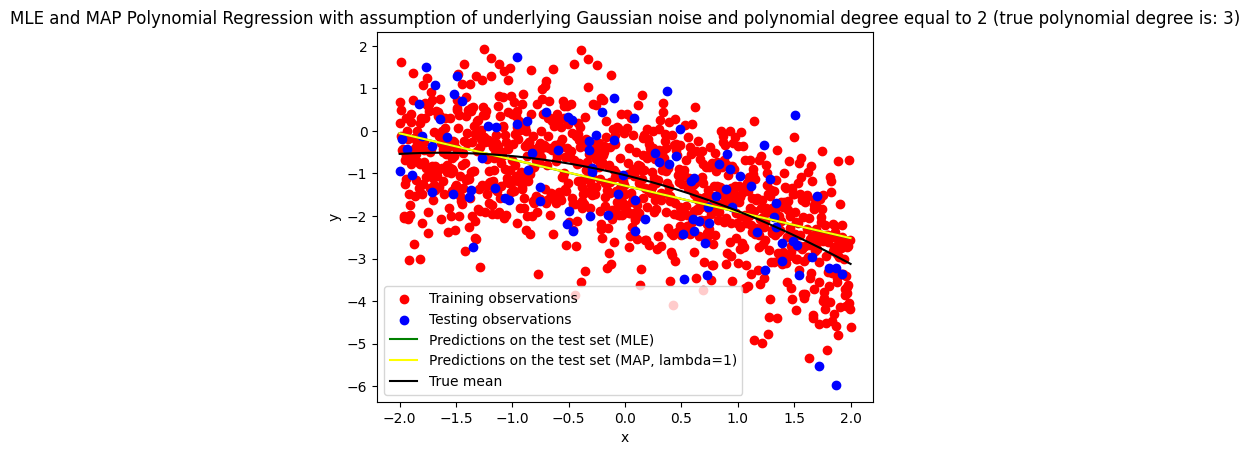

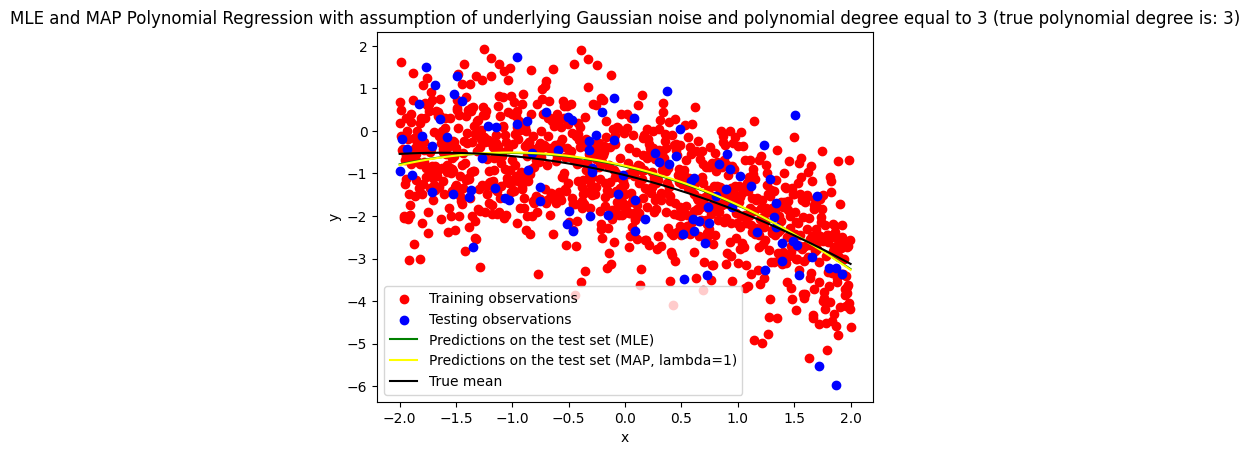

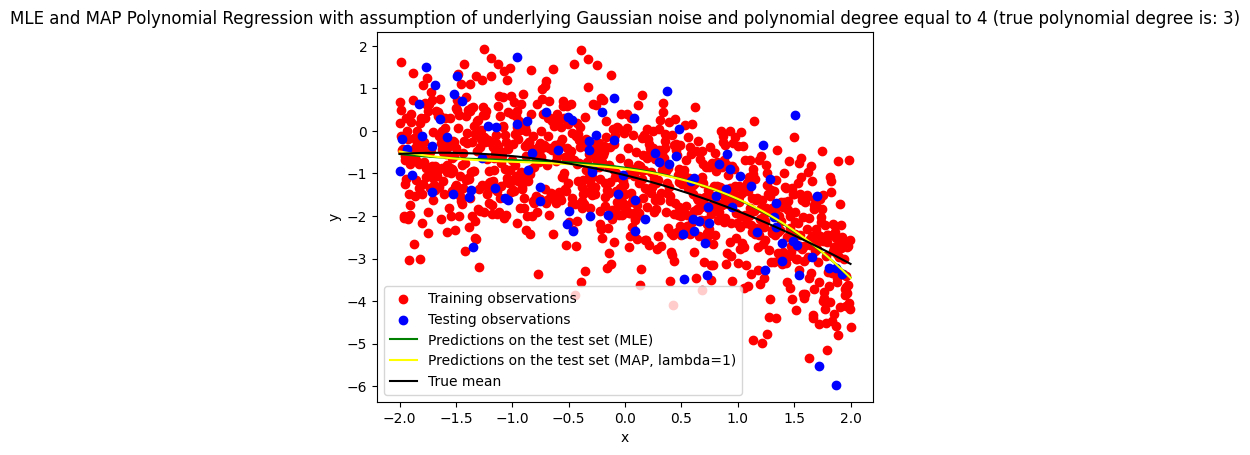

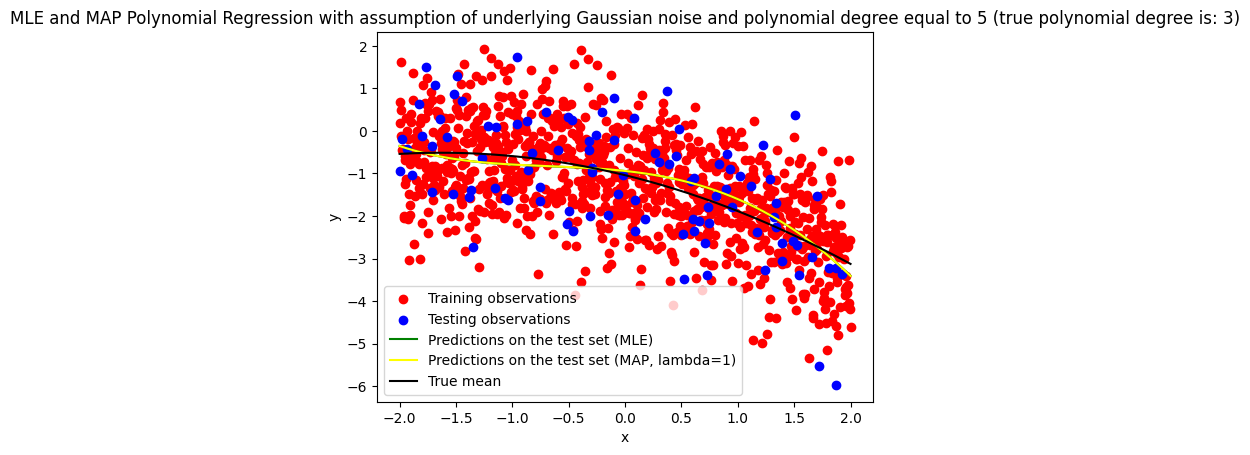

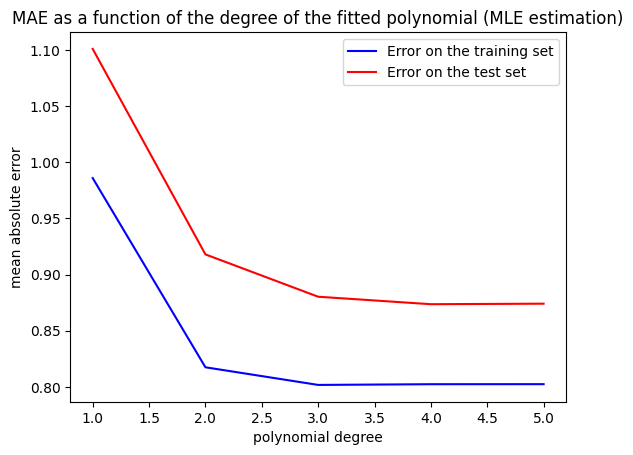

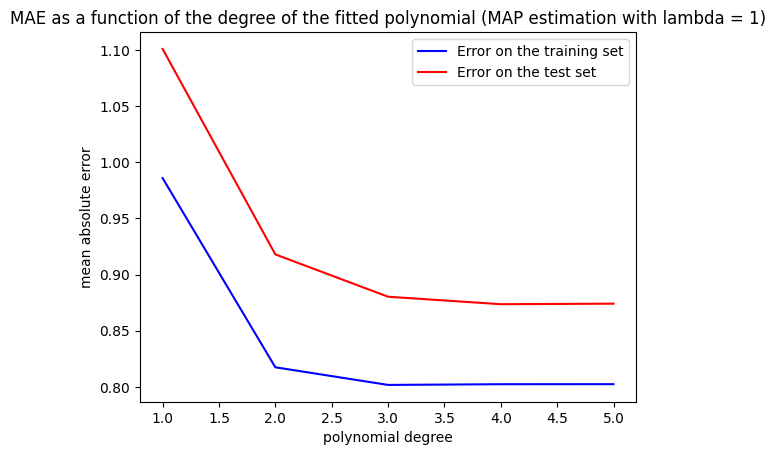

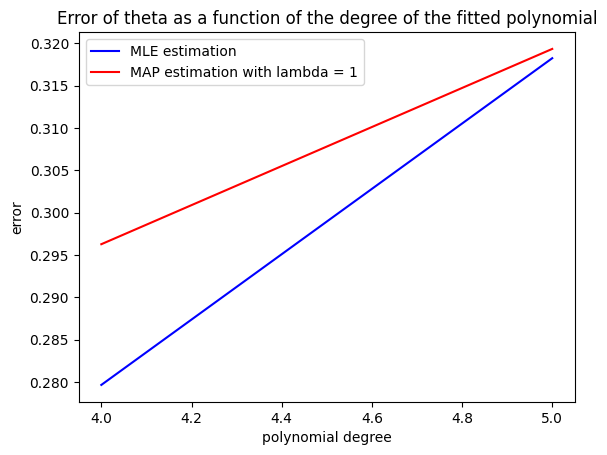

In [5]:
testMLEAndMAP(False, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.random.normal(0, 1, 3), optimization="sgd", kmax=500, regularization_par=1)

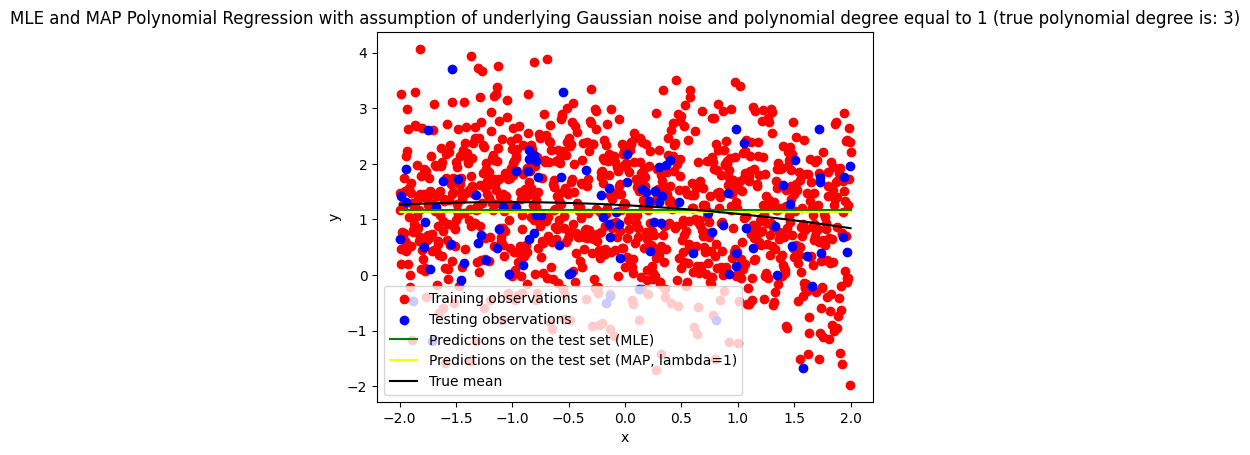

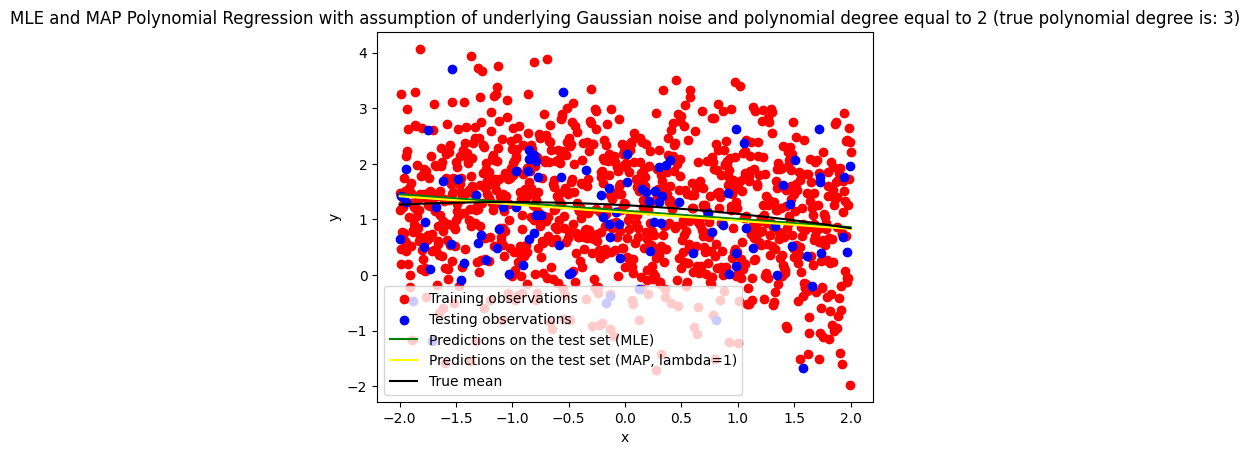

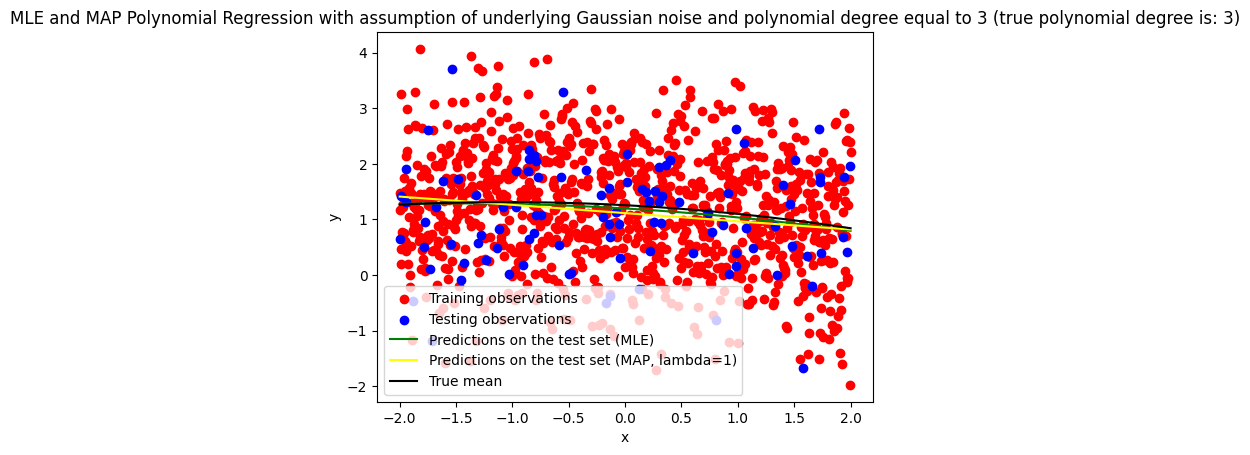

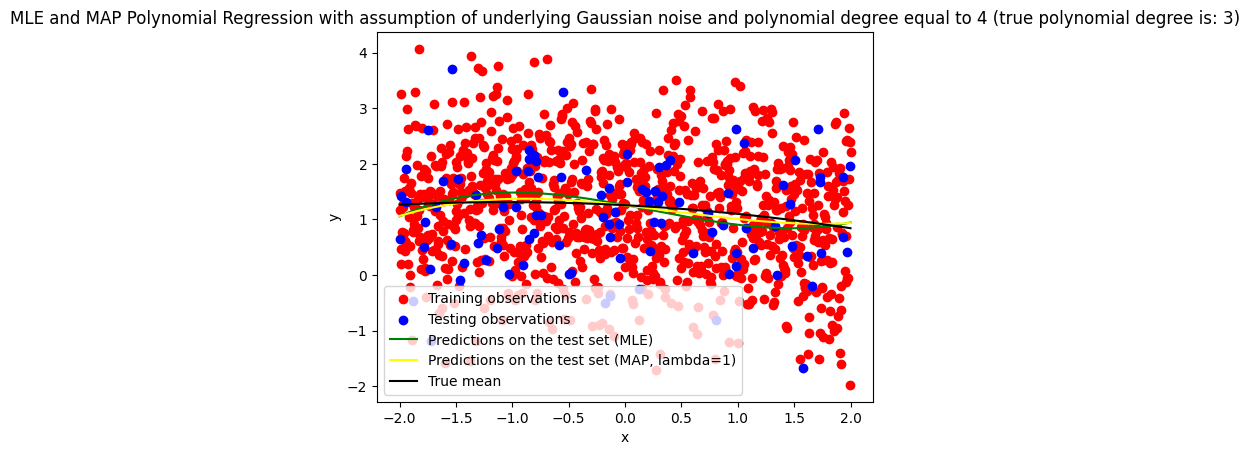

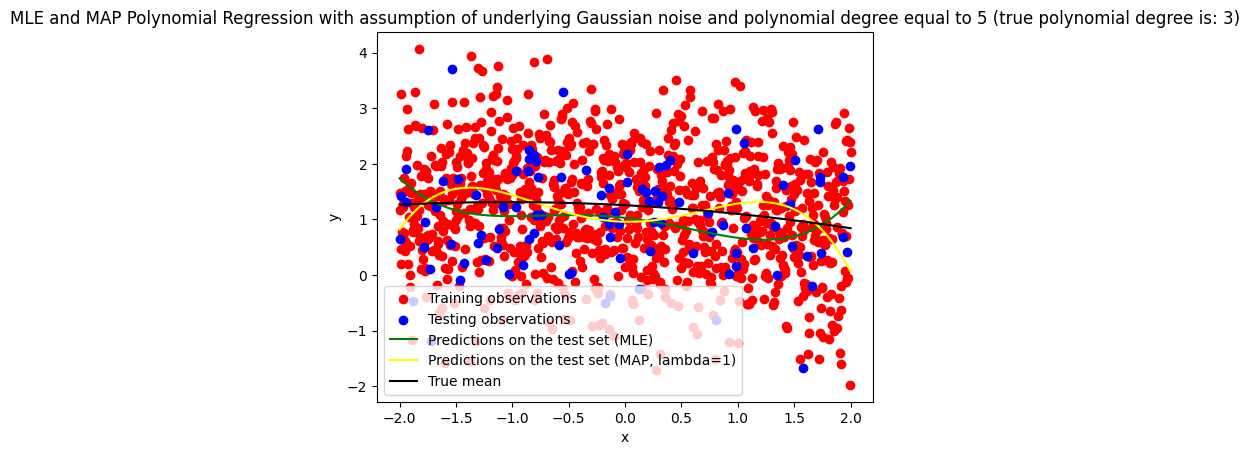

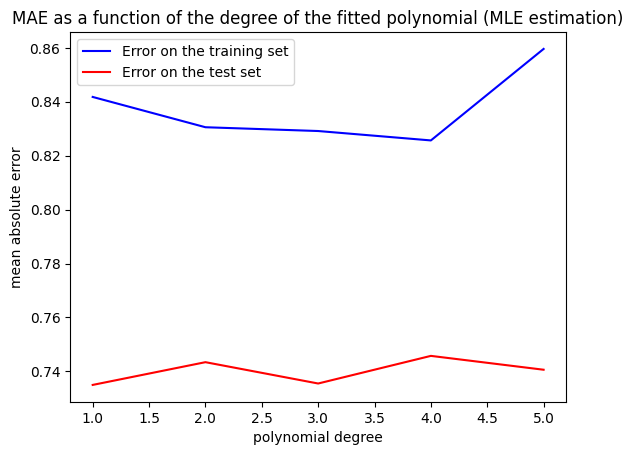

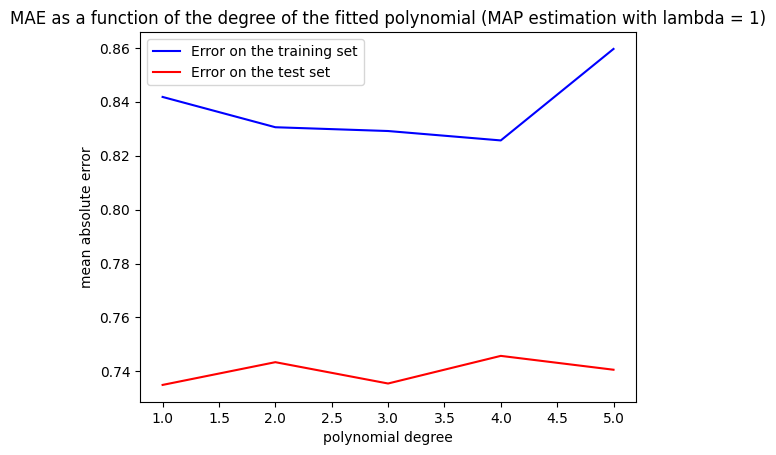

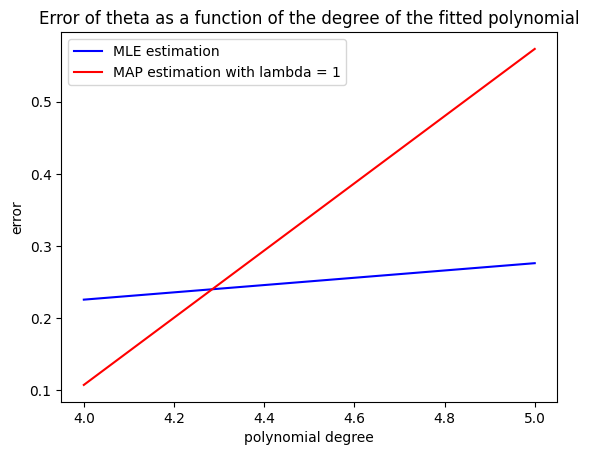

In [6]:
testMLEAndMAP(False, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.random.normal(0, 1, 3), optimization="adam", kmax=2000, regularization_par=1)

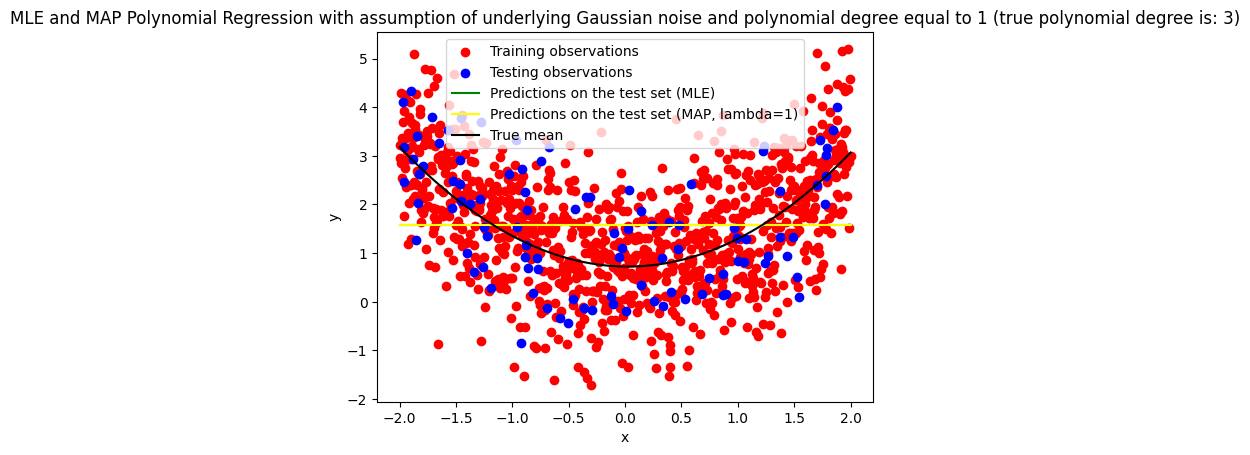

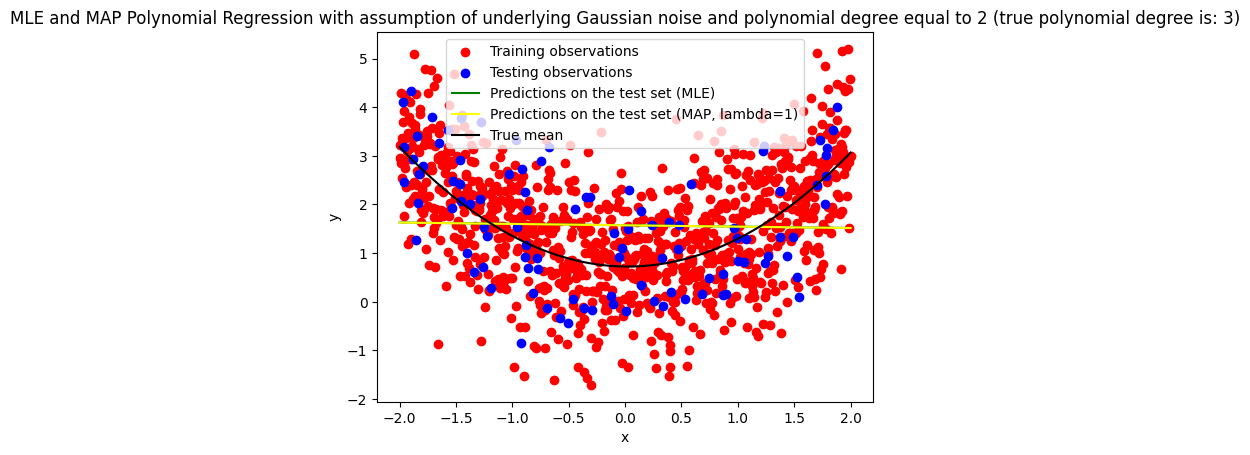

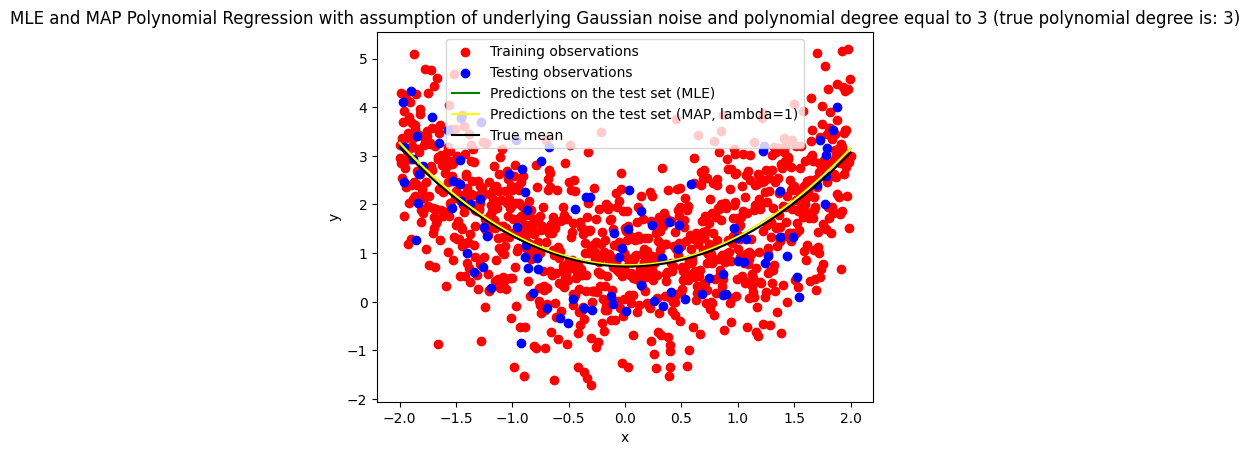

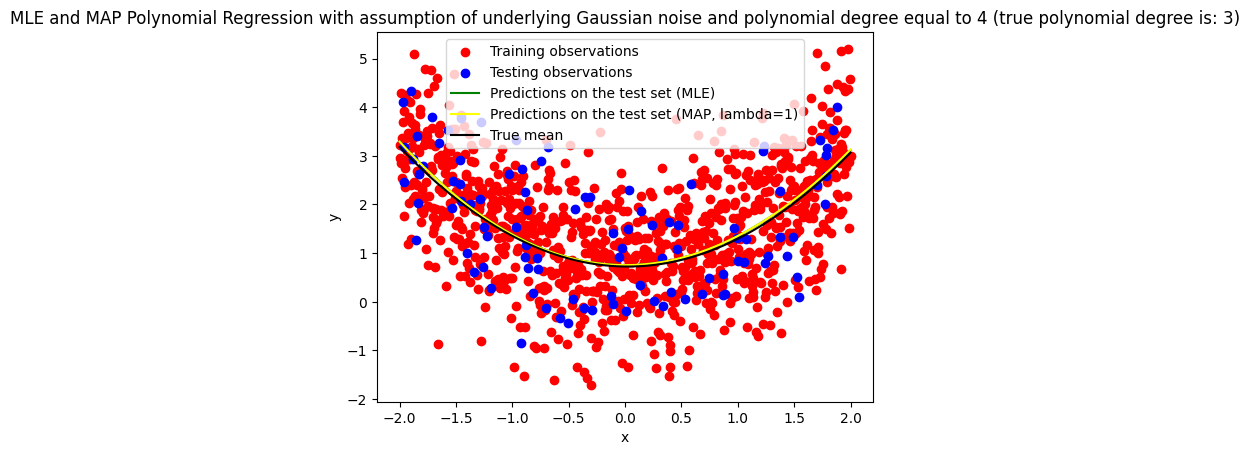

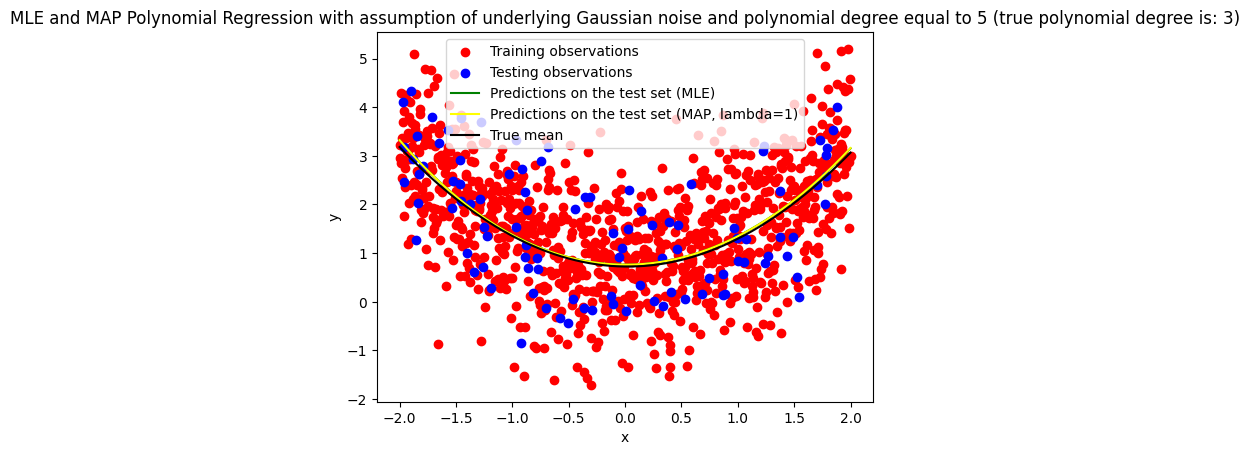

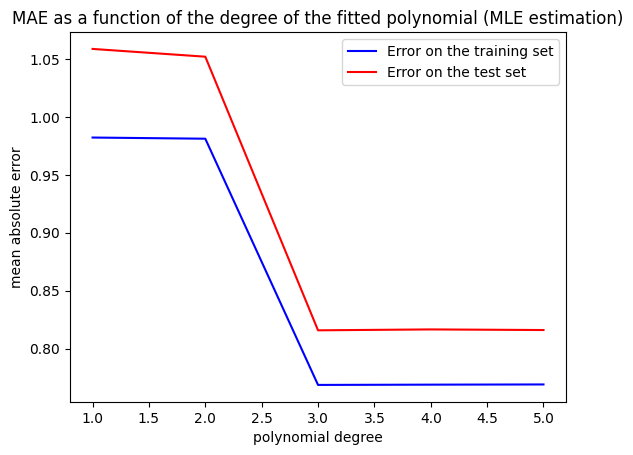

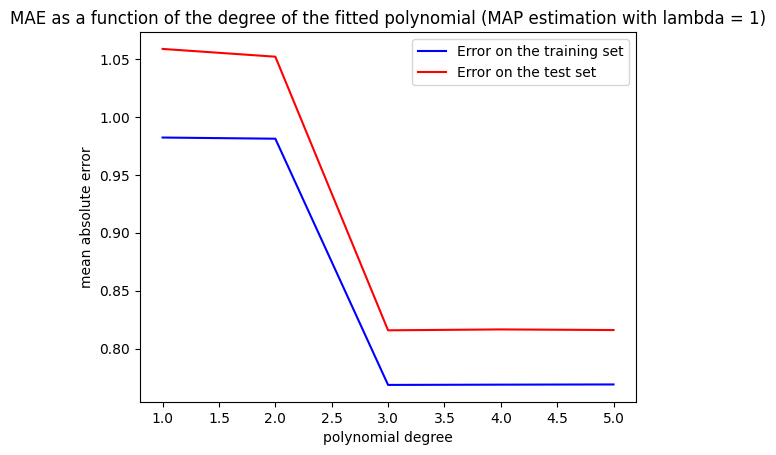

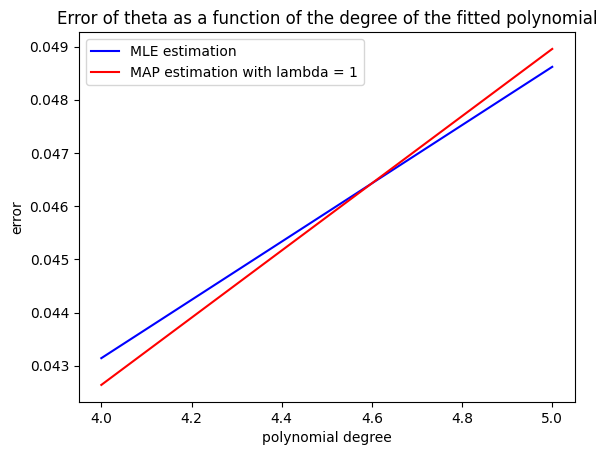

In [7]:
testMLEAndMAP(False, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.random.normal(0, 1, 3), optimization="rmsprop", kmax=2000, regularization_par=1)

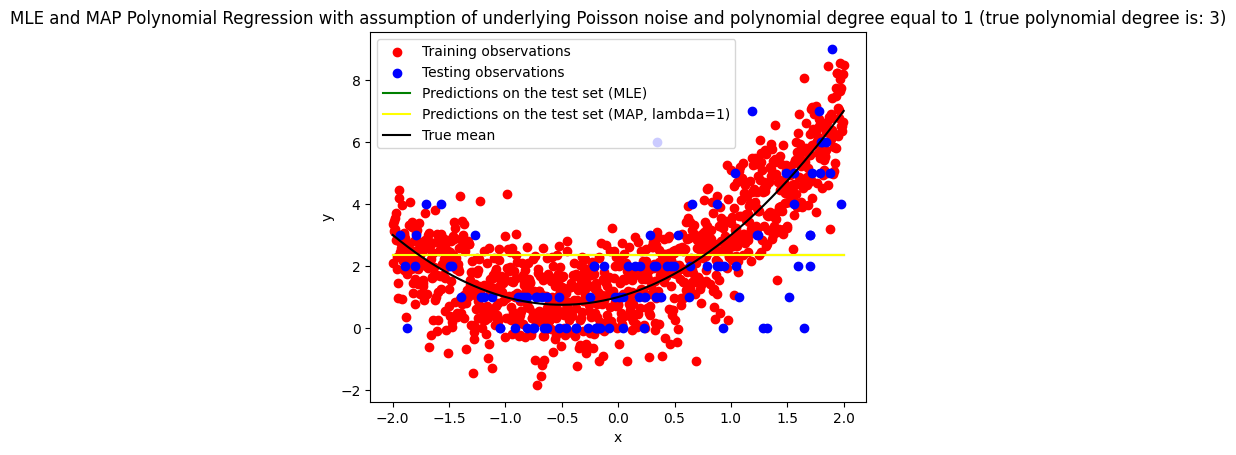

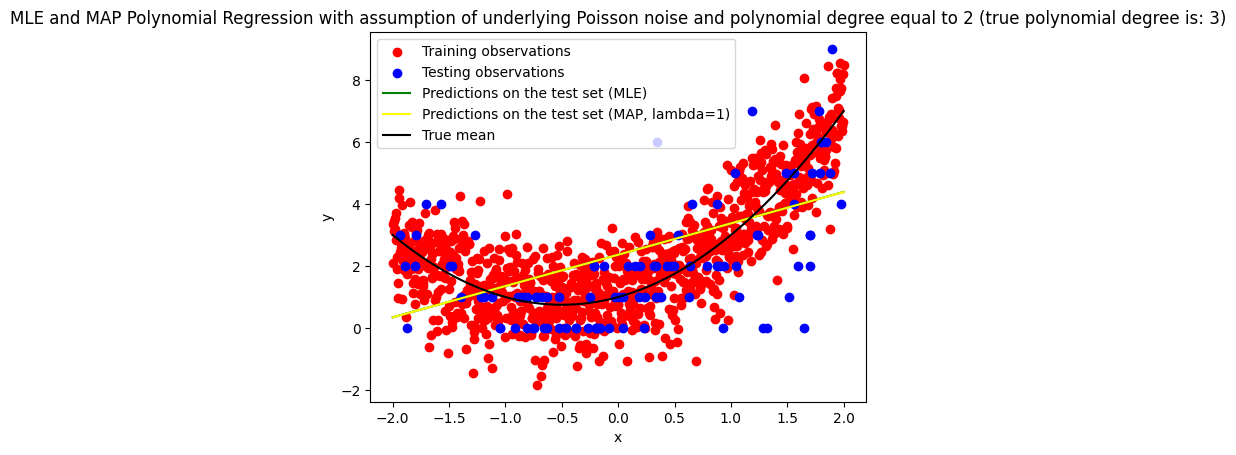

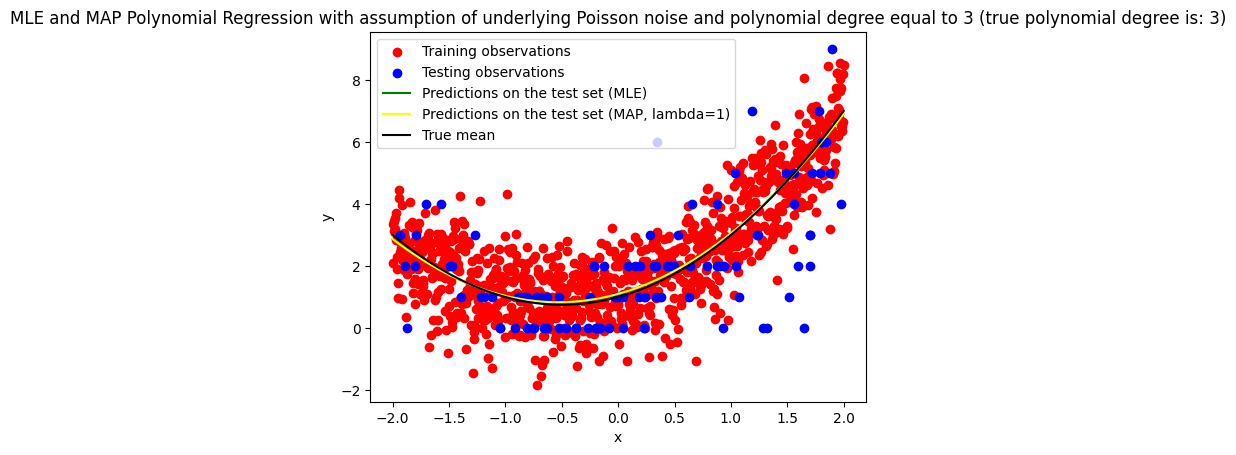

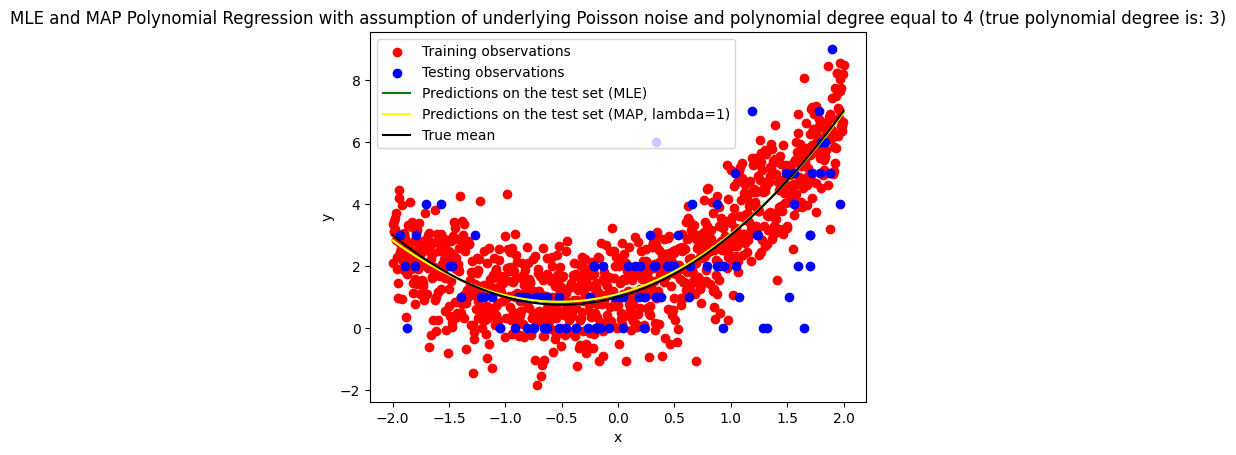

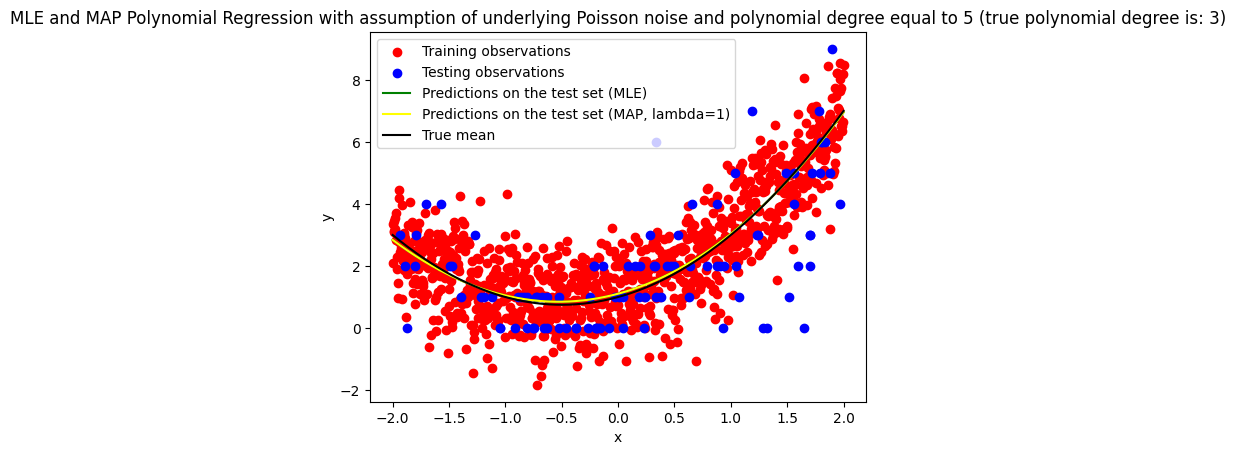

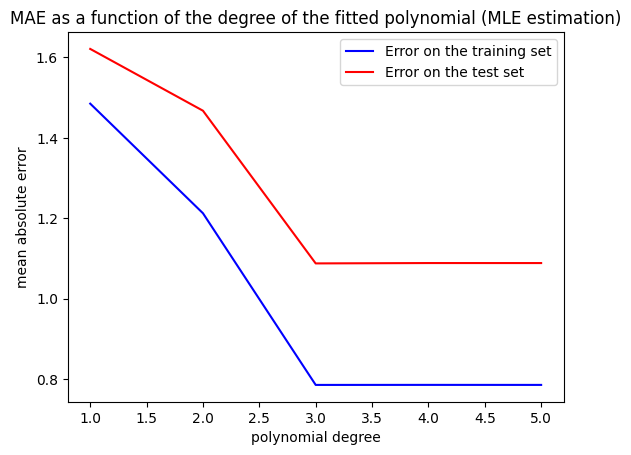

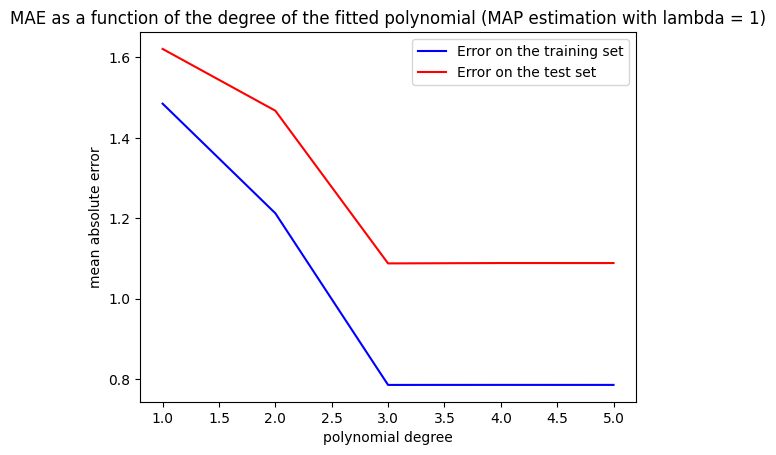

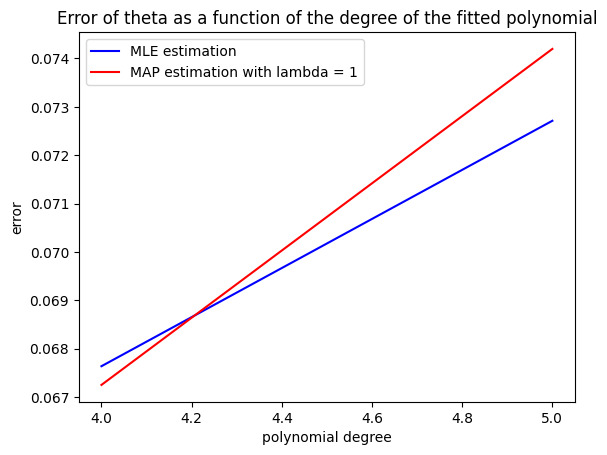

In [8]:
testMLEAndMAP(True, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.ones(3), optimization="exact", kmax=500, regularization_par=1)

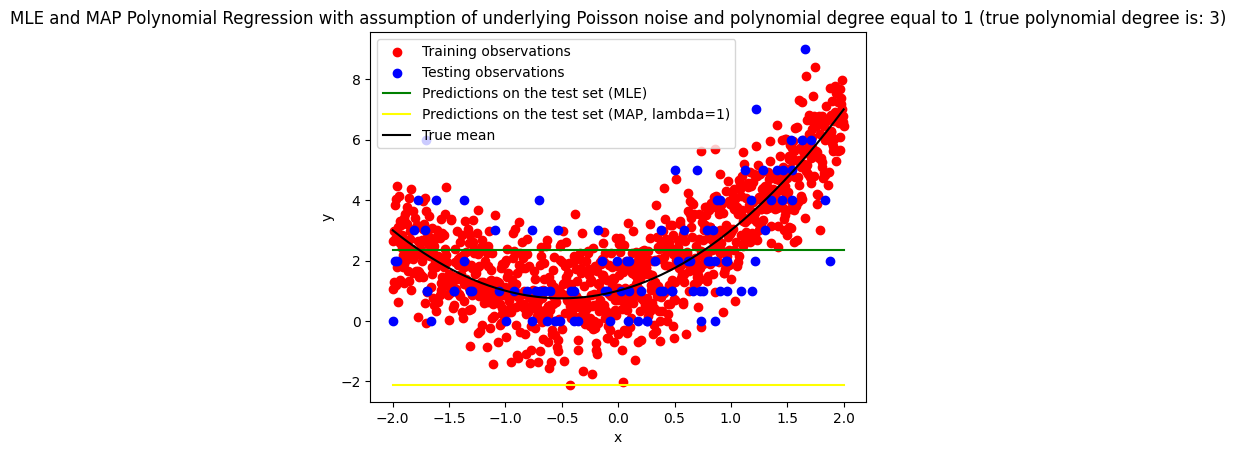

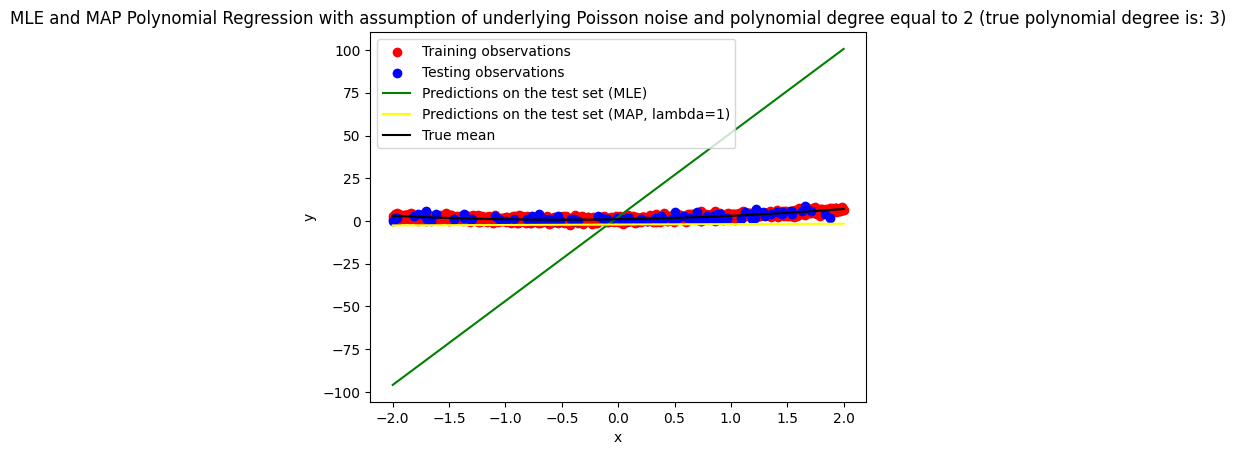

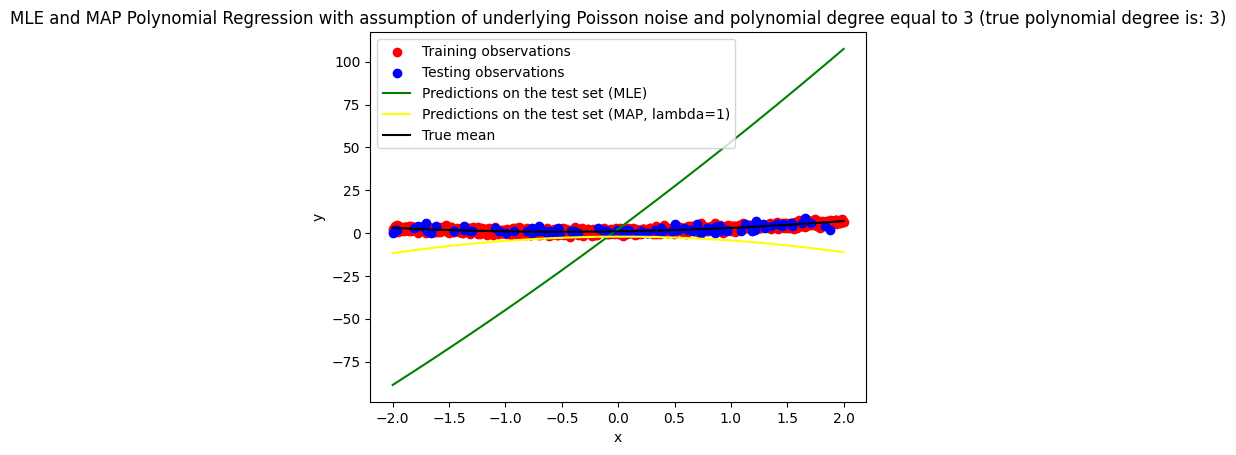

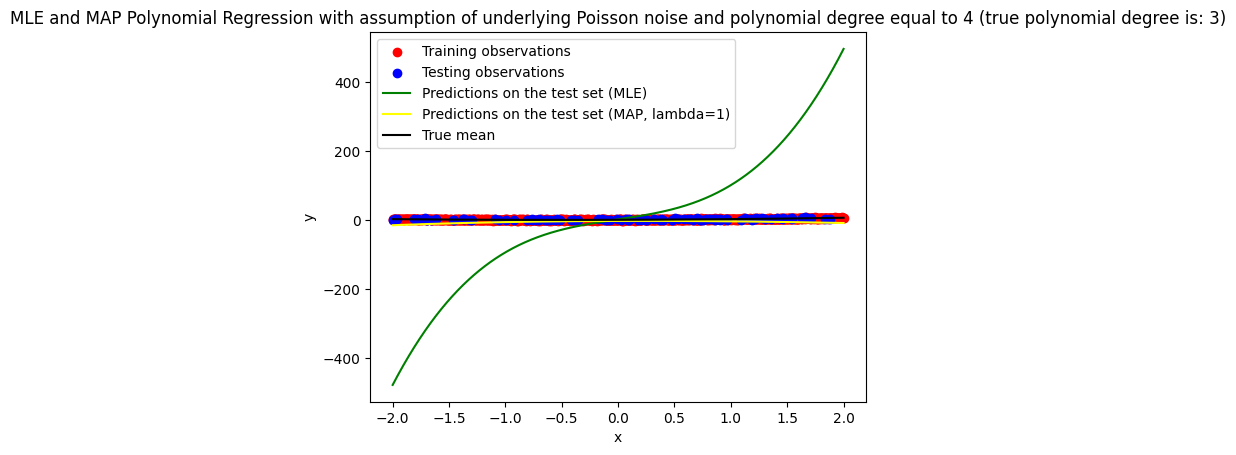

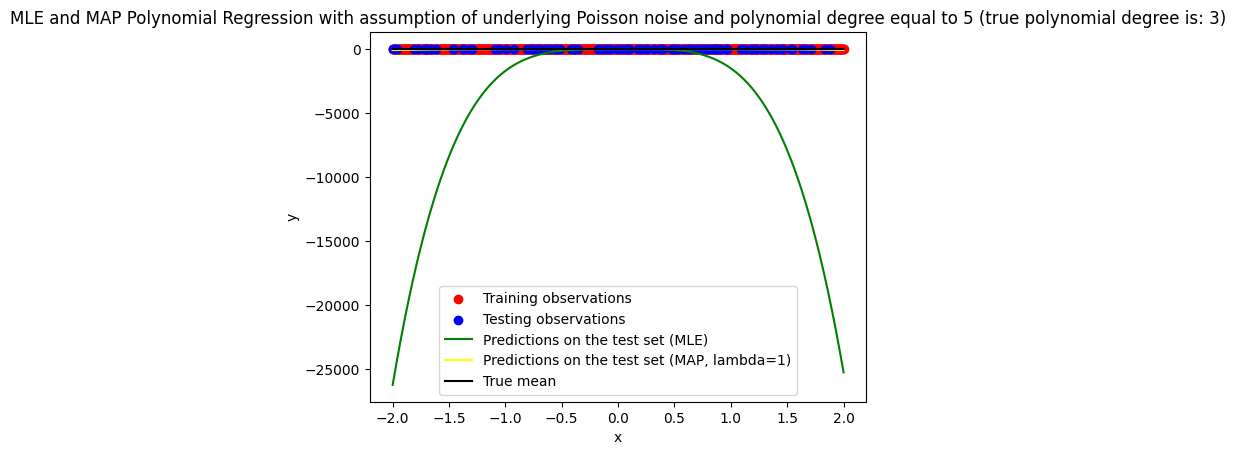

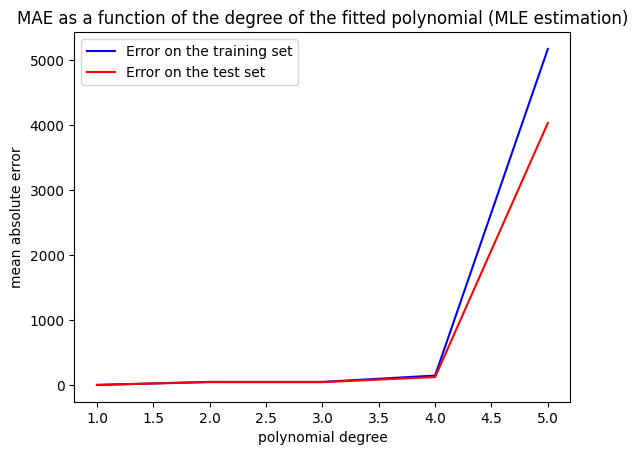

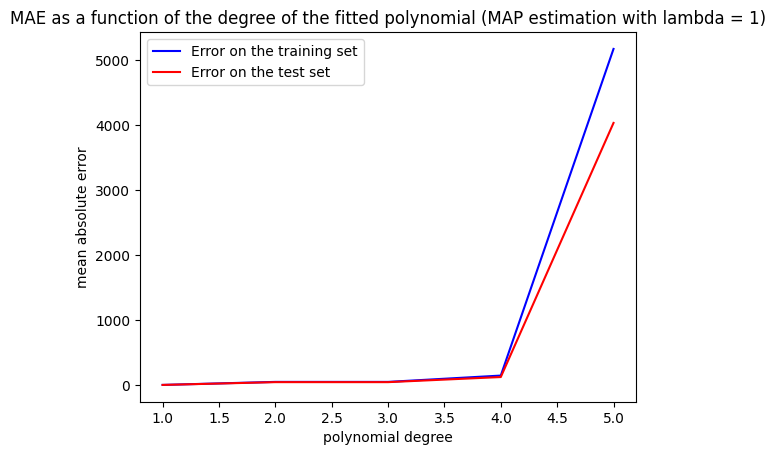

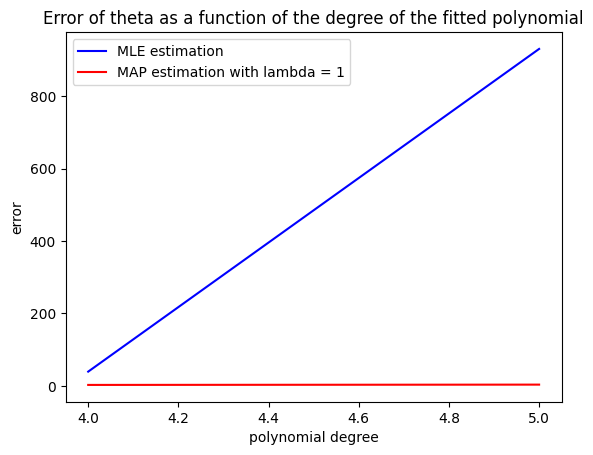

In [9]:
testMLEAndMAP(True, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.ones(3), optimization="gd", kmax=500, regularization_par=1)

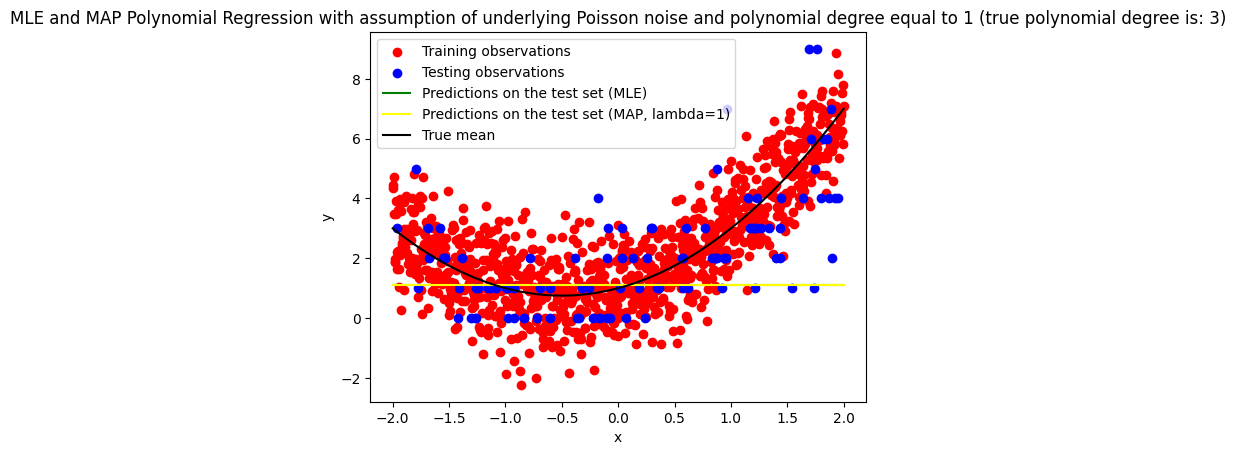

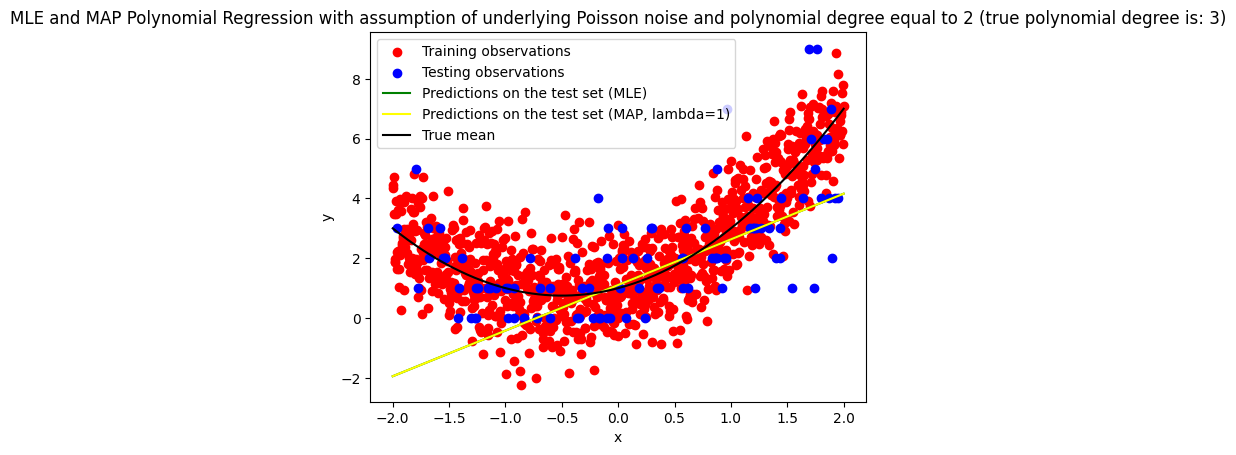

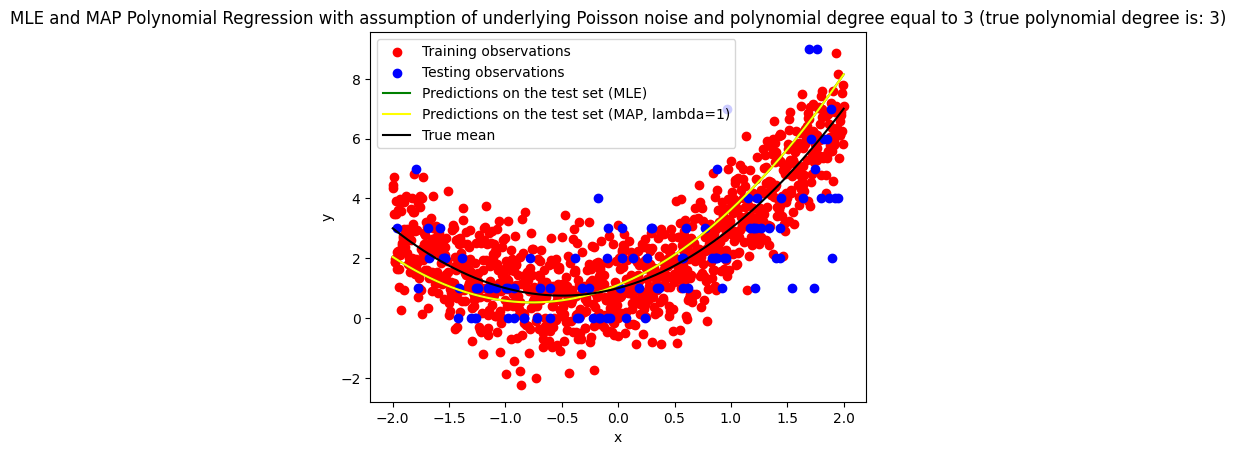

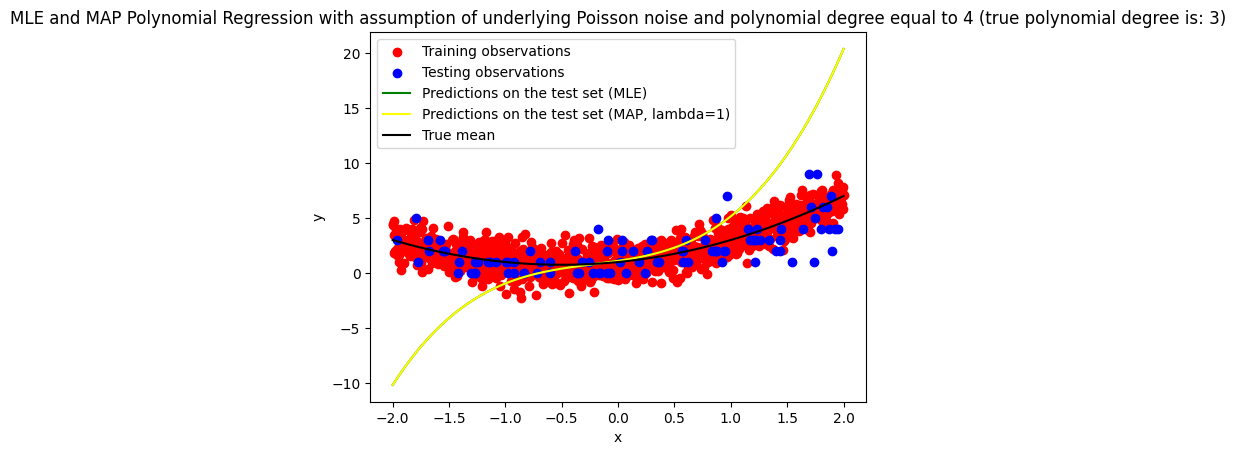

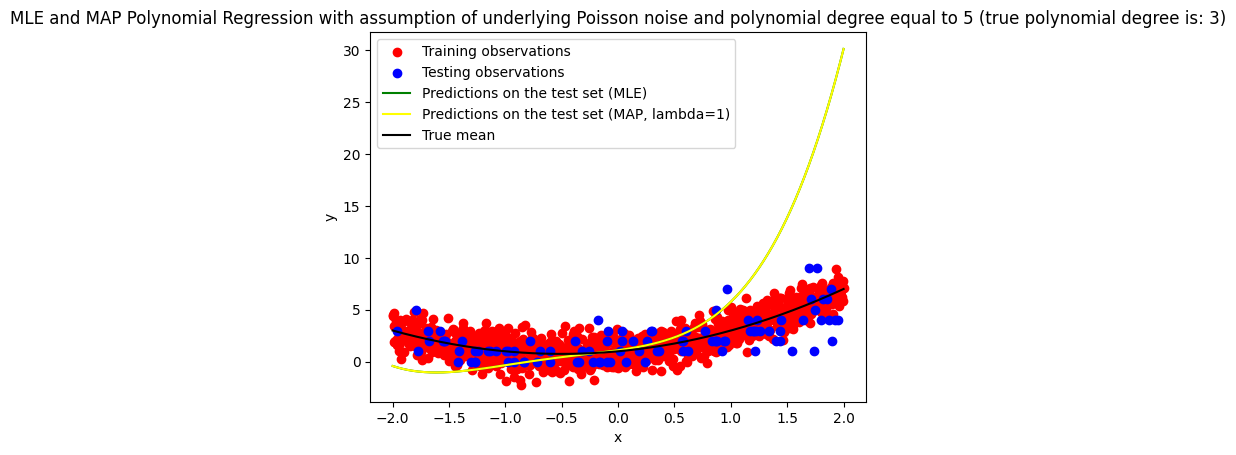

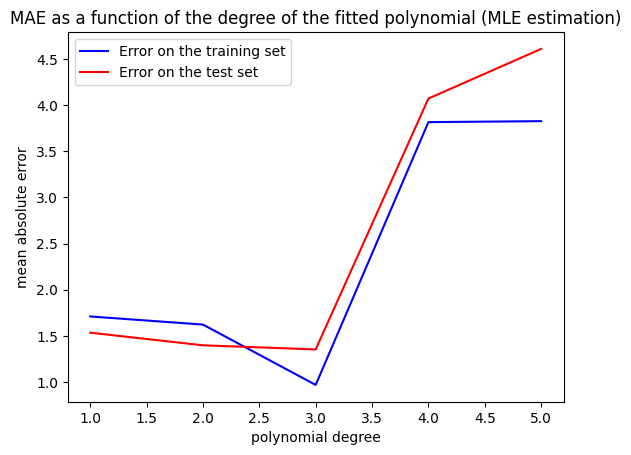

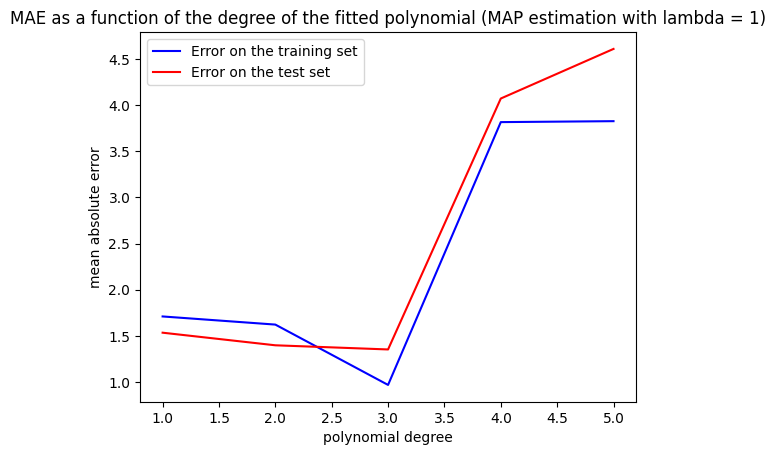

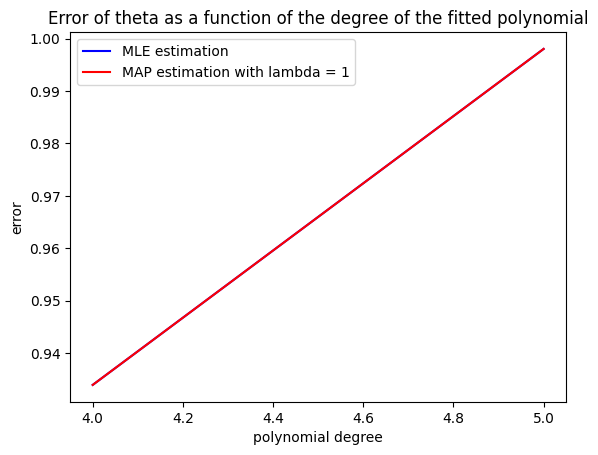

In [10]:
testMLEAndMAP(True, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.ones(3), optimization="sgd", kmax=500, regularization_par=1)

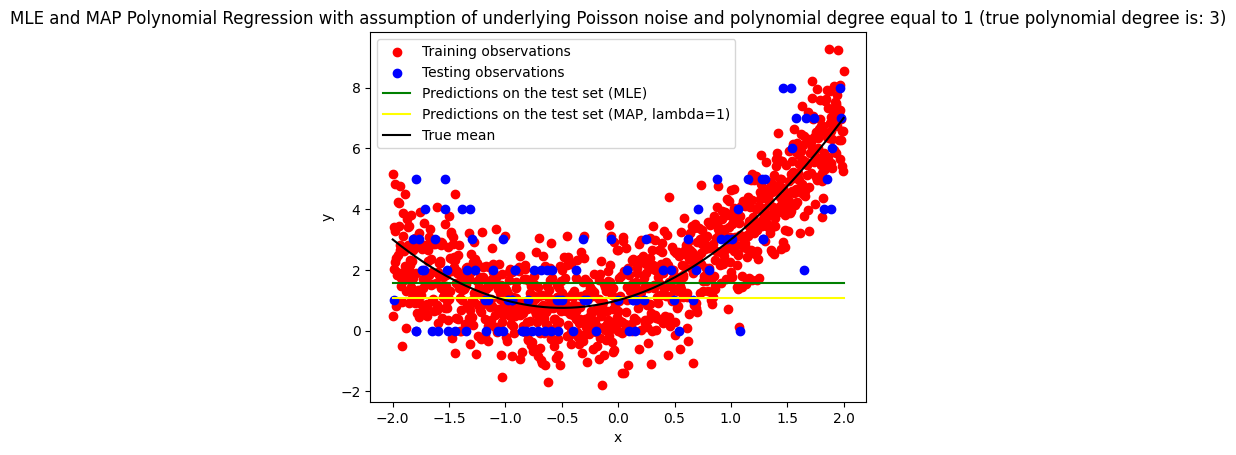

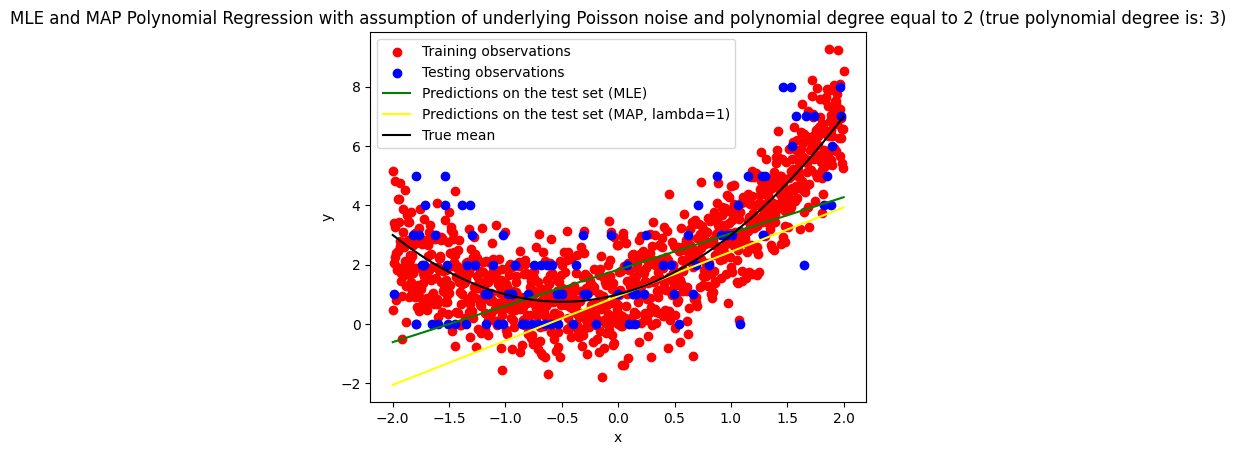

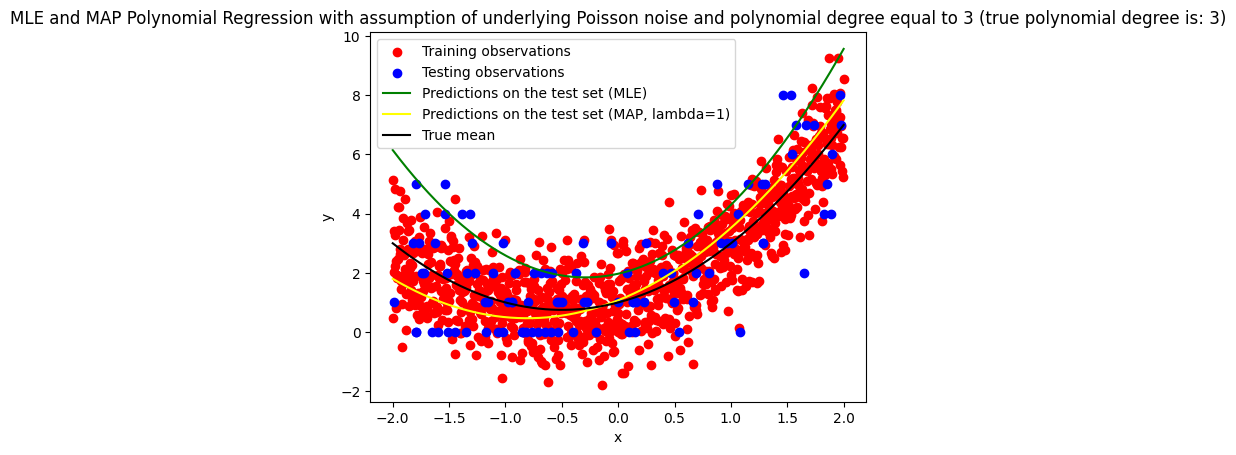

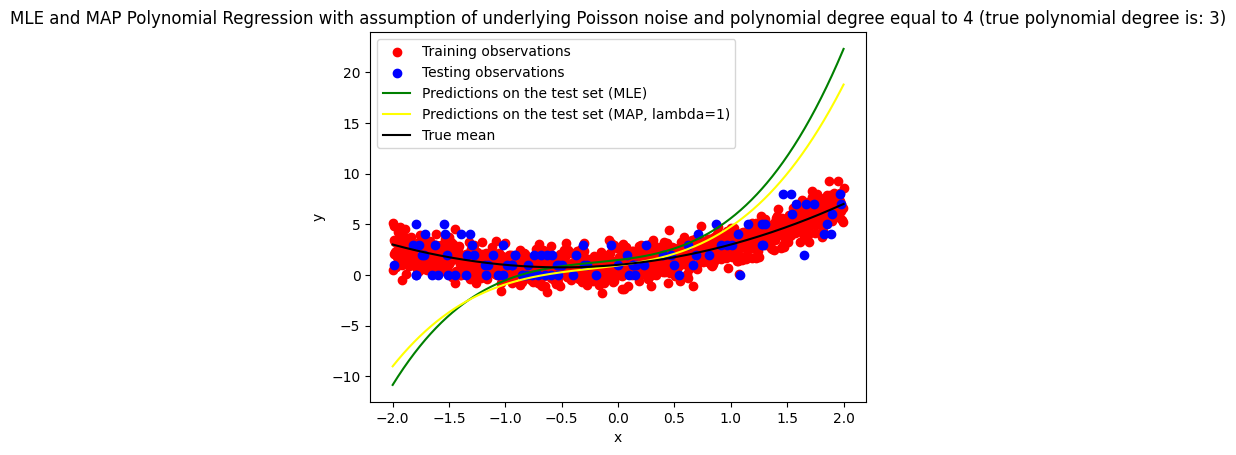

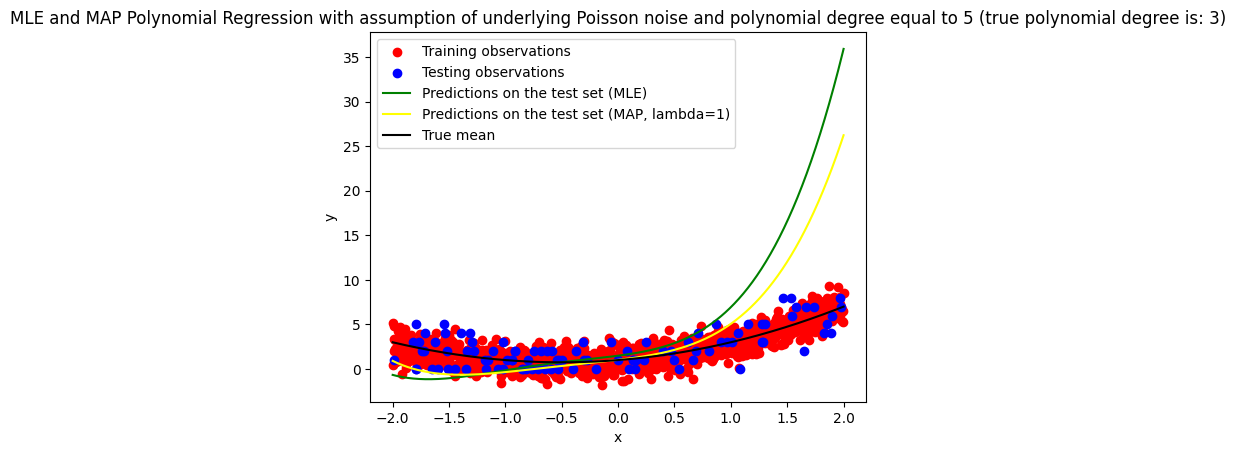

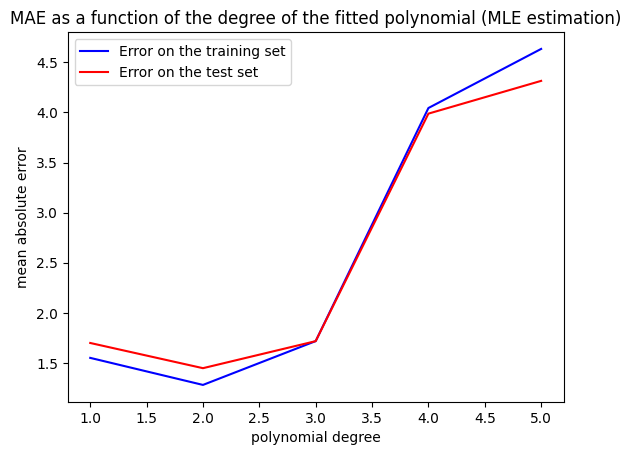

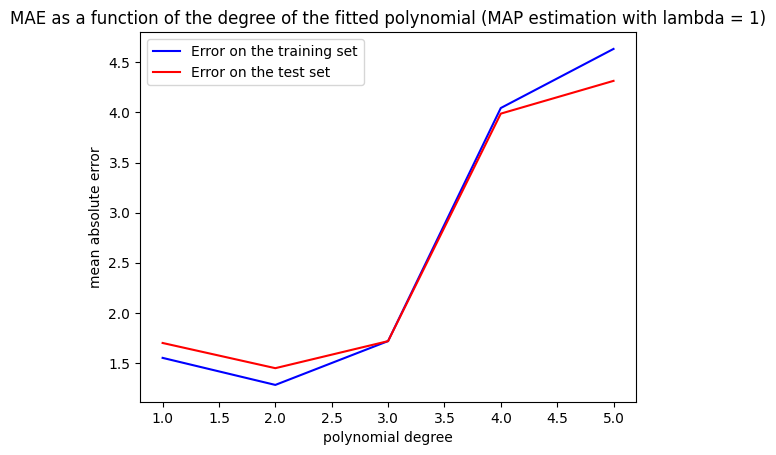

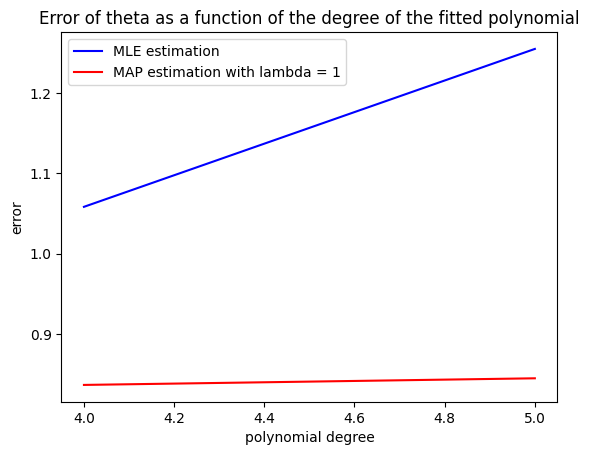

In [11]:
testMLEAndMAP(True, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.ones(3), optimization="adam", kmax=2000, regularization_par=1)

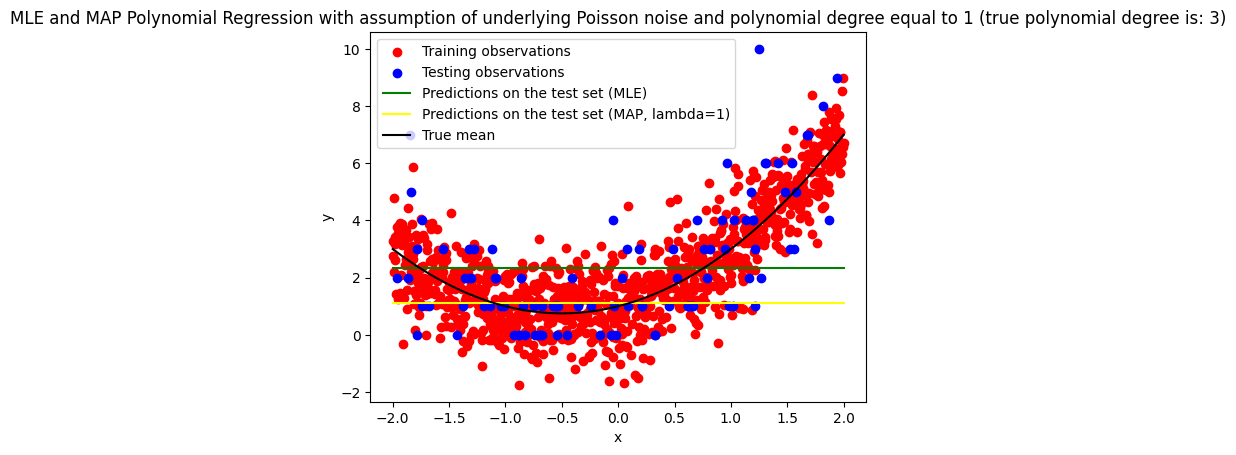

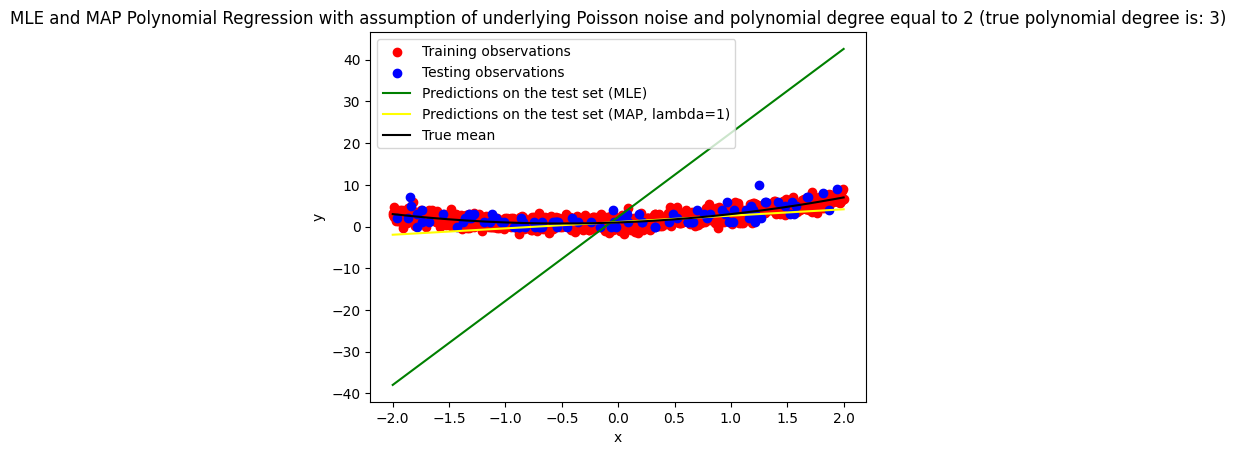

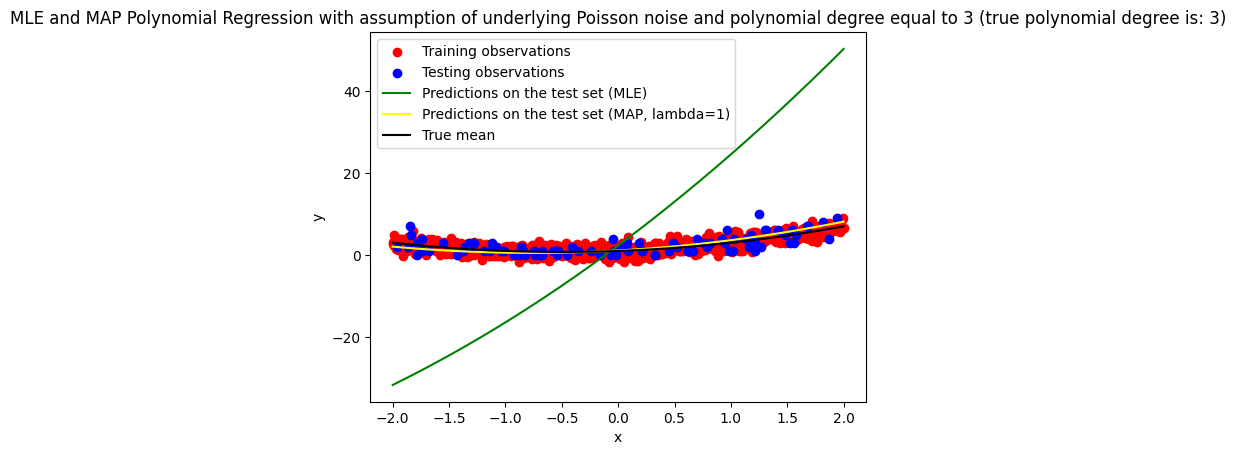

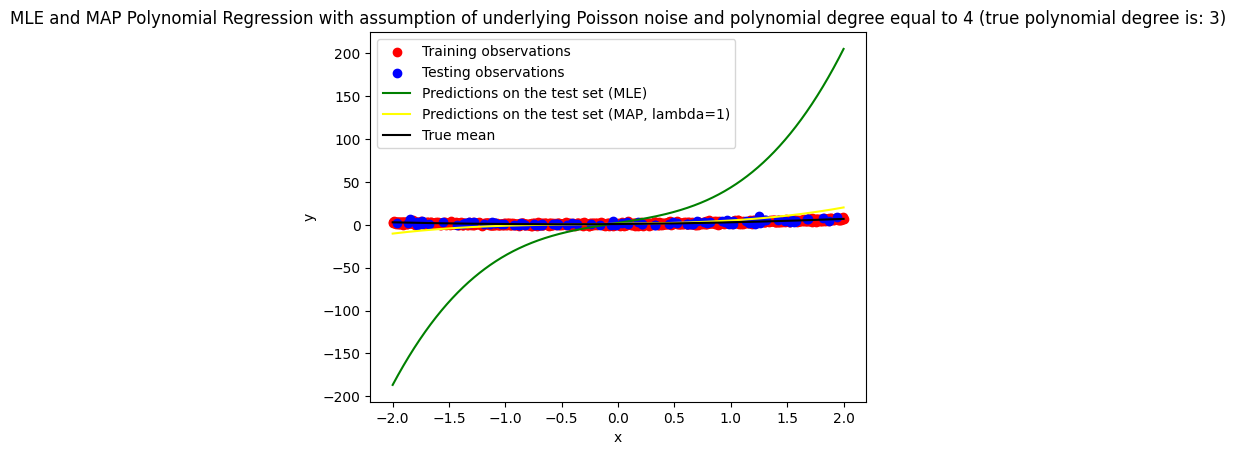

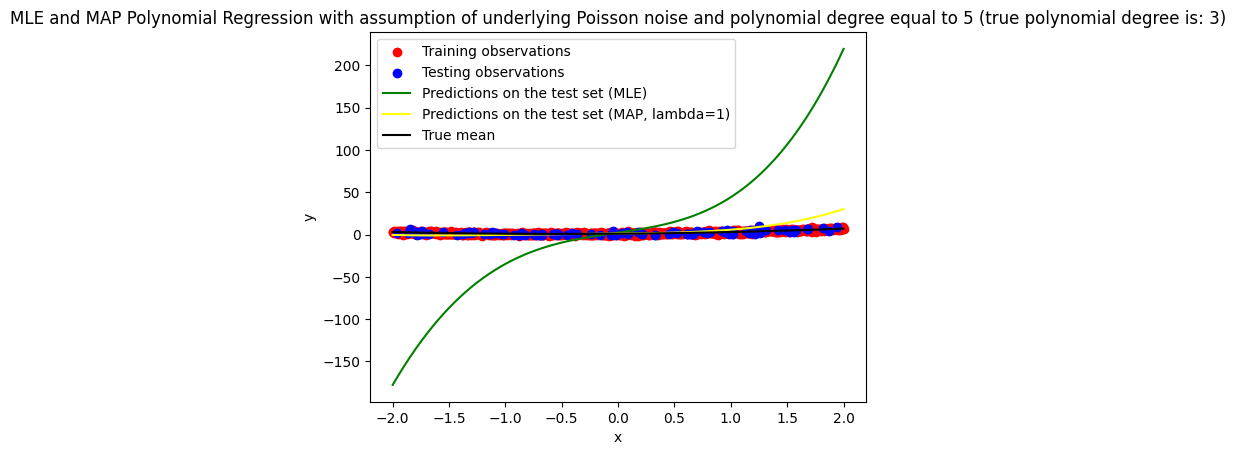

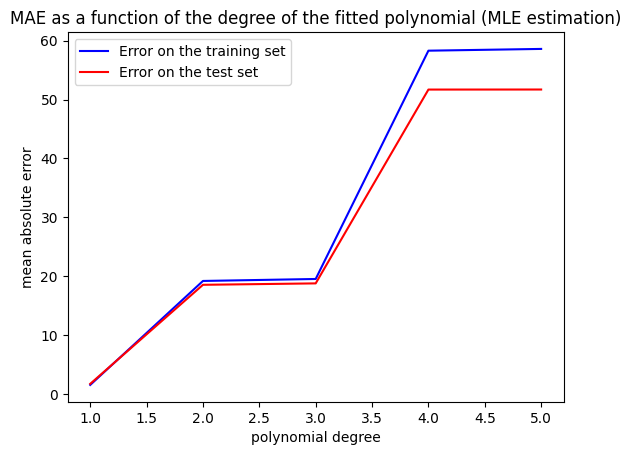

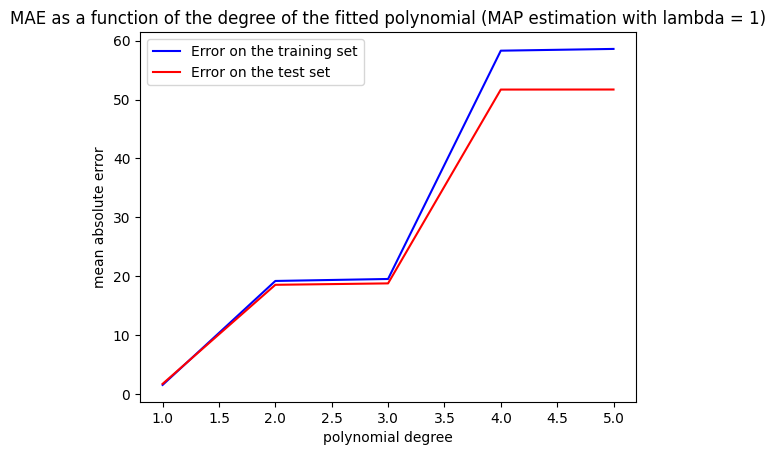

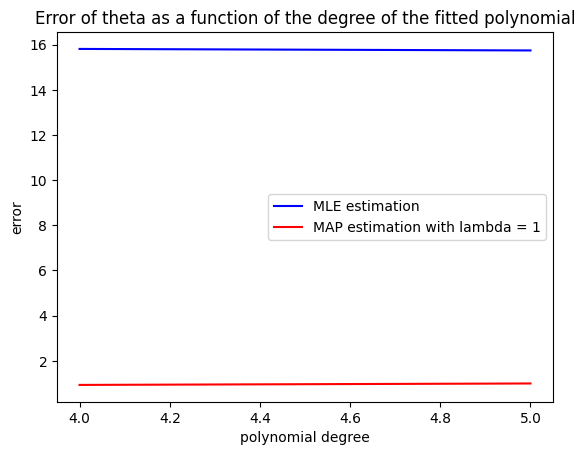

In [12]:
testMLEAndMAP(True, 3, a=-2, b=2, n_train=1000, n_test=100,theta_true=np.ones(3), optimization="rmsprop", kmax=2000, regularization_par=1)